---

## **Introduction to Turbo Codes**

Turbo codes, introduced by Claude Berrou in 1993, were the first practical channel codes to approach the **Shannon capacity limit**. Their breakthrough came from combining two ideas:

* **Parallel concatenation of two convolutional encoders**
* **Iterative decoding with soft information exchange**

They are called “**turbo**” due to the **feedback-like decoding loop**, reminiscent of a turbo engine’s feedback mechanism.


## **Basic Structure**

Turbo coding consists of:

### a. **Two Recursive Systematic Convolutional (RSC) Encoders**

* Connected in parallel
* Both encode the same input, but the second encoder sees an **interleaved** version of the input.

### b. **Interleaver**

* A deterministic or pseudorandom permutation of the input bits
* Introduces randomness to break low-weight input patterns (improves minimum distance)

### c. **Code Rate**

* The basic configuration transmits:

  * The **original input bits** (systematic)
  * One **parity bit** from each encoder
* Code rate:

  $$
  R = \frac{\text{Number of input bits}}{\text{Number of transmitted bits}} = \frac{k}{k + 2k} = \frac{1}{3}
  $$

  (Puncturing can increase it to 1/2, 2/3, etc.)


## **Encoding Process (Step-by-Step)**

1. Input data: $\mathbf{u} = [u_0, u_1, \dots, u_{k-1}]$
2. Encoder 1 takes $\mathbf{u}$ and produces parity bits $\mathbf{p}_1$
3. Interleaver scrambles $\mathbf{u} \rightarrow \mathbf{u}'$
4. Encoder 2 takes $\mathbf{u}'$ and produces parity bits $\mathbf{p}_2$
5. Transmitted bits:

   $$
   \mathbf{x} = \left[ u_0, p_{1,0}, p_{2,0}, u_1, p_{1,1}, p_{2,1}, \dots \right]
   $$


## **Recursive Systematic Convolutional (RSC) Encoder**

Each encoder is usually a **rate-1/2 RSC code**, implemented via:

* Shift registers
* Feedback and feedforward polynomials

For example, a **constraint length 3** encoder might use:

* Generator polynomials: $G_1 = 1 + D + D^2$, $G_2 = 1 + D^2$

These generate both:

* **Systematic bit**: Original input bit
* **Parity bit**: Based on current and previous input bits


## **Turbo Decoder (Iterative Decoding)**

Turbo decoding is performed iteratively using **two Soft-Input Soft-Output (SISO)** decoders:

### Step-by-Step:

1. Each decoder uses the **Log-MAP algorithm** or **Max-Log-MAP** to decode its stream, taking into account **a priori probabilities**.
2. Decoder 1 processes the systematic bits and its parity bits → produces **extrinsic LLRs**.
3. Interleaver permutes these extrinsic values → fed into Decoder 2.
4. Decoder 2 processes interleaved systematic bits and parity → updates extrinsic LLRs.
5. These are **deinterleaved** and passed back to Decoder 1.

Each iteration improves reliability of LLRs. After $N$ iterations, a **hard decision** is made:

$$
\hat{u}_i = \begin{cases}
1 & \text{if } L(u_i) > 0 \\
0 & \text{otherwise}
\end{cases}
$$


## **Mathematical Details of Decoding**

The **Log-MAP algorithm** computes the **log-likelihood ratio (LLR)** for each bit:

$$
L(u_i) = \log \frac{P(u_i = 1 | y)}{P(u_i = 0 | y)}
$$

The LLR is decomposed as:

$$
L(u_i) = L_c(y_i) + L_{a}(u_i) + L_e(u_i)
$$

Where:

* $L_c(y_i)$: channel LLR from received symbols
* $L_a(u_i)$: a priori info from other decoder
* $L_e(u_i)$: extrinsic info passed to other decoder


## **Performance and Properties**

| Property             | Turbo Code                           |
| -------------------- | ------------------------------------ |
| Capacity-Approaching | Yes                                  |
| Good at              | Moderate blocklength (1k–10k)        |
| Drawback             | Error floor at high SNR              |
| Complexity           | Medium-high due to iterations        |
| Used in              | 3G, 4G LTE data channels, deep space |


## **Turbo Code vs. Block Code**

Turbo codes achieve high performance by:

* **Interleaving**, which increases effective free distance
* **Iterative decoding**, improving reliability per iteration
* **Soft information exchange**, unlike traditional block codes


## **Diagram Summary**

```
Input:  u0 u1 u2 u3 ...

  ┌──────────────┐
  │   Encoder 1  │─────→ parity 1
  └──────────────┘
        │
        │ systematic bits → TX
        ▼
  ┌──────────────┐
  │  Interleaver │──→ permuted input
  └──────────────┘
        ▼
  ┌──────────────┐
  │   Encoder 2  │─────→ parity 2
  └──────────────┘
```

At receiver:

* Decoder 1 ⇄ Decoder 2 (via interleaver/deinterleaver)
* Iteratively exchange **LLRs**




--- 

### Custom Turbo Code Implementation 


### 1. **Recursive Systematic Convolutional (RSC) Encoder**

* Constraint length $K = 3$
* Generator polynomials: $G_1 = (1, 1, 1)$, $G_2 = (1, 0, 1)$

    * $G_1$ is the systematic path
    * $G_2$ is the feedback parity path

### 2. **Turbo Encoder**

* Two identical RSC encoders
* One processes original bits
* The other processes interleaved bits

### 3. **Turbo Decoder (Iterative)**

* A basic version of **Soft-In Soft-Out (SISO)** decoding using **Log-MAP** (or approximation)
* Exchange **extrinsic information** between the two decoders
* Use **a priori + channel + extrinsic** LLRs




In [2]:
import numpy as np
import matplotlib.pyplot as plt
# ===========================
# 1. Recursive Systematic Convolutional Encoder (RSC)
# ===========================
class RSCEncoder:
    def __init__(self, g_sys, g_parity):
        """
        g_sys, g_parity: generator polynomials as lists of bits, e.g., [1, 1, 1]
        """
        self.g_sys = np.array(g_sys)
        self.g_parity = np.array(g_parity)
        self.K = len(g_sys)

    def encode(self, bits):
        """
        Encodes a bit array using a rate-1/2 RSC encoder.
        Returns: (systematic_bits, parity_bits)
        """
        state = np.zeros(self.K - 1, dtype=int)
        sys_bits = []
        parity_bits = []

        for bit in bits:
            sys_bits.append(bit)

            # Compute feedback = input XOR feedback terms
            feedback = bit
            for i in range(1, self.K):
                feedback ^= self.g_sys[i] & state[i - 1]

            # Compute parity = feedback XOR parity terms
            parity = feedback * self.g_parity[0]
            for i in range(1, self.K):
                parity ^= self.g_parity[i] & state[i - 1]
            parity_bits.append(parity)

            # Update shift register
            state = np.roll(state, shift=1)
            state[0] = feedback

        return np.array(sys_bits), np.array(parity_bits)


if __name__ == "__main__":
    np.random.seed(0)
    test_bits = np.random.randint(0, 2, 10)
    encoder = RSCEncoder(g_sys=[1, 1, 1], g_parity=[1, 0, 1])
    sys, parity = encoder.encode(test_bits)

    print("Input:        ", test_bits)
    print("Systematic:   ", sys)
    print("Parity:       ", parity)




Input:         [0 1 1 0 1 1 1 1 1 1]
Systematic:    [0 1 1 0 1 1 1 1 1 1]
Parity:        [0 1 0 0 0 1 1 0 1 1]


In [3]:
# ===========================
# 2. Interleaver / Deinterleaver
# ===========================
class Interleaver:
    def __init__(self, pattern):
        """
        pattern: a permutation of indices for interleaving (e.g., np.random.permutation(N))
        """
        self.pattern = np.array(pattern)
        self.inverse_pattern = np.argsort(self.pattern)

    def interleave(self, bits):
        return bits[self.pattern]

    def deinterleave(self, bits):
        return bits[self.inverse_pattern]


if __name__ == "__main__":
    bits = np.array([0, 1, 1, 0, 1, 0])
    pattern = np.random.permutation(len(bits))
    interleaver = Interleaver(pattern)

    interleaved = interleaver.interleave(bits)
    recovered = interleaver.deinterleave(interleaved)

    print("Original Bits:   ", bits)
    print("Interleaved:     ", interleaved)
    print("Deinterleaved:   ", recovered)


Original Bits:    [0 1 1 0 1 0]
Interleaved:      [1 0 1 0 1 0]
Deinterleaved:    [0 1 1 0 1 0]


In [4]:
# ===========================
# 3. Turbo Encoder
# ===========================

class TurboEncoder:
    def __init__(self, g_sys, g_parity, interleaver):
        """
        g_sys, g_parity: generator polynomials
        interleaver: instance of Interleaver
        """
        self.encoder1 = RSCEncoder(g_sys, g_parity)
        self.encoder2 = RSCEncoder(g_sys, g_parity)
        self.interleaver = interleaver

    def encode(self, info_bits):
        """
        Returns:
            sys_bits: Systematic bits (from encoder 1)
            parity1: Parity bits from encoder 1
            parity2: Parity bits from encoder 2 (interleaved input)
            interleaved_bits: Interleaved version of info_bits
        """
        sys_bits, parity1 = self.encoder1.encode(info_bits)
        interleaved_bits = self.interleaver.interleave(info_bits)
        _, parity2 = self.encoder2.encode(interleaved_bits)
        return sys_bits, parity1, parity2, interleaved_bits


if __name__ == "__main__":
    np.random.seed(0)
    info_bits = np.random.randint(0, 2, 10)
    interleaver_pattern = np.random.permutation(len(info_bits))
    interleaver = Interleaver(interleaver_pattern)

    encoder = TurboEncoder(g_sys=[1, 1, 1], g_parity=[1, 0, 1], interleaver=interleaver)
    sys, p1, p2, interleaved = encoder.encode(info_bits)

    print("Info Bits:       ", info_bits)
    print("Systematic Bits: ", sys)
    print("Parity 1:        ", p1)
    print("Parity 2:        ", p2)
    print("Interleaved Bits:", interleaved)


Info Bits:        [0 1 1 0 1 1 1 1 1 1]
Systematic Bits:  [0 1 1 0 1 1 1 1 1 1]
Parity 1:         [0 1 0 0 0 1 1 0 1 1]
Parity 2:         [0 1 0 1 1 1 0 0 0 0]
Interleaved Bits: [0 1 1 1 1 0 1 1 1 1]


In [5]:
# ===========================
# 4. Log-MAP approximation for SISO Decoder (max-log-MAP)
# ===========================
class SISODecoder:
    def __init__(self, g_sys, g_parity, noise_var):
        self.noise_var = noise_var
        self.states = 4  # for constraint length 3
        self.trellis = self._build_trellis(g_sys, g_parity)

    def _build_trellis(self, g_sys, g_parity):
        # Build manually for constraint length = 3
        trellis = {}
        for s in range(4):
            for u in [0, 1]:
                current_state = list(map(int, np.binary_repr(s, width=2)))
                input_bit = u

                # Feedback (RSC)
                fb = input_bit ^ (g_sys[1] & current_state[0]) ^ (g_sys[2] & current_state[1])
                parity = fb ^ (g_parity[1] & current_state[0]) ^ (g_parity[2] & current_state[1])

                next_state = (fb << 1) | current_state[0]
                next_state &= 0b11  # 2-bit state
                trellis[(s, u)] = (next_state, parity)
        return trellis

    def decode(self, y_sys, y_parity, apriori):
        N = len(y_sys)
        alpha = np.full((N + 1, 4), -np.inf)
        beta = np.full((N + 1, 4), -np.inf)
        alpha[0, 0] = 0
        beta[N, :] = 0  # all states equally likely at the end

        # Forward alpha
        for k in range(N):
            for s_prev in range(4):
                for u in [0, 1]:
                    s_next, parity = self.trellis[(s_prev, u)]
                    metric = -0.5 / self.noise_var * (
                        (2*u - 1 - y_sys[k])**2 + (2*parity - 1 - y_parity[k])**2
                    ) + apriori[k]*u
                    alpha[k+1, s_next] = max(alpha[k+1, s_next], alpha[k, s_prev] + metric)

        # Backward beta
        for k in reversed(range(N)):
            for s_next in range(4):
                for s_prev in range(4):
                    for u in [0, 1]:
                        if self.trellis.get((s_prev, u), (None,))[0] == s_next:
                            parity = self.trellis[(s_prev, u)][1]
                            metric = -0.5 / self.noise_var * (
                                (2*u - 1 - y_sys[k])**2 + (2*parity - 1 - y_parity[k])**2
                            ) + apriori[k]*u
                            beta[k, s_prev] = max(beta[k, s_prev], beta[k+1, s_next] + metric)

        # LLR output
        extrinsic = np.zeros(N)
        for k in range(N):
            num = -np.inf
            den = -np.inf
            for s_prev in range(4):
                for u in [0, 1]:
                    s_next, parity = self.trellis[(s_prev, u)]
                    metric = alpha[k, s_prev] + beta[k+1, s_next] + \
                             (-0.5 / self.noise_var * ((2*u - 1 - y_sys[k])**2 + (2*parity - 1 - y_parity[k])**2)) + \
                             apriori[k] * u
                    if u == 1:
                        num = max(num, metric)
                    else:
                        den = max(den, metric)
            extrinsic[k] = num - den

        return extrinsic





In [6]:
# ===========================
# 5. Full Turbo Decoder (Iterative)
# ===========================

class TurboDecoder:
    def __init__(self, g_sys, g_parity, interleaver, noise_var, n_iter=5):
        """
        g_sys, g_parity: generator polynomials
        interleaver: Interleaver instance
        noise_var: noise variance of the AWGN channel
        n_iter: number of decoding iterations
        """
        self.interleaver = interleaver
        self.siso1 = SISODecoder(g_sys, g_parity, noise_var)
        self.siso2 = SISODecoder(g_sys, g_parity, noise_var)
        self.n_iter = n_iter

    def decode(self, rx_sys, rx_p1, rx_p2):
        """
        rx_sys: received noisy systematic (LLR)
        rx_p1: received noisy parity1 (LLR)
        rx_p2: received noisy parity2 (LLR)
        Returns:
            decoded_bits: final hard decision after n_iter iterations
            final_llr: final LLRs from decoder 1
        """
        N = len(rx_sys)
        apriori1 = np.zeros(N)

        for _ in range(self.n_iter):
            # Decoder 1
            llr1 = self.siso1.decode(rx_sys, rx_p1, apriori1)
            extrinsic1 = llr1 - apriori1
            apriori2 = self.interleaver.interleave(extrinsic1)

            # Decoder 2
            inter_rx_sys = self.interleaver.interleave(rx_sys)
            llr2 = self.siso2.decode(inter_rx_sys, rx_p2, apriori2)
            extrinsic2 = llr2 - apriori2
            apriori1 = self.interleaver.deinterleave(extrinsic2)

        final_llr = llr1
        decoded_bits = (final_llr >= 0).astype(int)
        return decoded_bits, final_llr




In [7]:
# ===========================
# Step 6: AWGN simulation with BER measurement and plotting.
# ===========================

class TurboSimulation:
    def __init__(self, g_sys, g_parity, block_len, n_iter=5):
        self.g_sys = g_sys
        self.g_parity = g_parity
        self.block_len = block_len
        self.n_iter = n_iter

    def bpsk_mod(self, bits):
        return 1 - 2 * bits  # 0 → +1, 1 → -1

    def run(self, snr_db, num_blocks=20):
        snr_linear = 10 ** (snr_db / 10)
        noise_var = 1 / (2 * snr_linear)
        sigma = np.sqrt(noise_var)

        total_errors = 0
        total_bits = 0

        for _ in range(num_blocks):
            info_bits = np.random.randint(0, 2, self.block_len)
            interleaver_pattern = np.random.permutation(self.block_len)
            interleaver = Interleaver(interleaver_pattern)

            encoder = TurboEncoder(self.g_sys, self.g_parity, interleaver)
            sys_bits, p1_bits, p2_bits, _ = encoder.encode(info_bits)

            tx_sys = self.bpsk_mod(sys_bits)
            tx_p1 = self.bpsk_mod(p1_bits)
            tx_p2 = self.bpsk_mod(p2_bits)

            rx_sys = tx_sys + sigma * np.random.randn(self.block_len)
            rx_p1  = tx_p1 + sigma * np.random.randn(self.block_len)
            rx_p2  = tx_p2 + sigma * np.random.randn(self.block_len)

            rx_sys_llr = 2 * rx_sys / noise_var
            rx_p1_llr  = 2 * rx_p1  / noise_var
            rx_p2_llr  = 2 * rx_p2  / noise_var

            decoder = TurboDecoder(self.g_sys, self.g_parity, interleaver, noise_var, self.n_iter)
            decoded_bits, _ = decoder.decode(rx_sys_llr, rx_p1_llr, rx_p2_llr)

            total_errors += np.sum(decoded_bits != info_bits)
            total_bits += self.block_len

        ber = total_errors / total_bits
        return ber




In [ ]:
if __name__ == "__main__":
    import matplotlib.pyplot as plt

    sim = TurboSimulation(g_sys=[1,1,1], g_parity=[1,0,1], block_len=5000, n_iter=6)
    snr_range = np.arange(0, 3.5, 0.5)
    ber_values = [sim.run(snr_db,num_blocks = 30) for snr_db in snr_range]

    plt.figure()
    plt.semilogy(snr_range, ber_values, marker='o')
    plt.grid(True, which='both')
    plt.title("Turbo Code BER vs. SNR (Max-Log-MAP, 6 Iterations)")
    plt.xlabel("SNR (dB)")
    plt.ylabel("Bit Error Rate (BER)")
    plt.tight_layout()
    plt.show()

--- 

## **Polar codes** 

Invented by Erdal Arıkan in 2009, are the **first class of error-correcting codes** that are **mathematically proven to achieve the capacity** of binary-input symmetric memoryless channels (B-DMC), such as the Binary Erasure Channel (BEC) and AWGN.

### Core Idea: Channel Polarization

The fundamental idea behind polar codes is called **channel polarization**. Given a communication channel $W$, we construct $N = 2^n$ **synthesized channels** $W_1, W_2, ..., W_N$, such that:

* Some channels become **almost noiseless** ($\text{capacity} \to 1$)
* Others become **completely noisy** ($\text{capacity} \to 0$)

We then:

* Transmit data bits over the **good (reliable)** channels
* Fix the inputs of **bad (unreliable)** channels to known values (called **frozen bits**)

### Polar Encoding

#### a. **Input Vector**

Let:

* $\mathbf{u} = [u_0, u_1, \dots, u_{N-1}]$: message + frozen bits
* $N = 2^n$: block length

#### b. **Polar Transform**

Encoding is done via:

$$
\mathbf{x} = \mathbf{u} \cdot G_N
$$

Where:

* $G_N = B_N \cdot F^{\otimes n}$
* $F = \begin{bmatrix}1 & 0 \\ 1 & 1\end{bmatrix}$
* $F^{\otimes n}$ is the **n-th Kronecker power**
* $B_N$: bit-reversal permutation matrix

The polar transform mixes bits so that some synthesized channels become more reliable than others.


### Frozen vs Information Bits

Once channels are polarized:

* Select **K** most reliable channels → assign **data bits**
* Remaining $N - K$ → assign **frozen bits** (usually zero)

These positions are **precomputed** based on channel type (e.g., AWGN) and SNR using **Bhattacharyya parameters** or **density evolution**.

### Decoding: Successive Cancellation (SC)

SC decoding proceeds **bit by bit**:

$$
\hat{u}_i = \begin{cases}
0 & \text{if } i \text{ is frozen} \\
\arg\max_{u_i} P(u_i | y, \hat{u}_0^{i-1}) & \text{otherwise}
\end{cases}
$$

* Uses **LLR recursion**
* Early decisions affect later ones
* Very fast (complexity $O(N \log N)$)

### Successive Cancellation List (SCL) Decoding

SC decoding suffers from:

* Poor performance at short blocklengths
* High error rate due to early decision errors

**SCL decoding** improves performance by:

* Keeping a **list of the best decoding paths**
* Selecting the final codeword using a **CRC check** (used in 5G NR)

SCL-CRC is the **standard decoding method** in real systems.


### Example: $N = 8$ Polar Code

* Block length $N = 8$
* K = 4 data bits, 4 frozen bits
* Frozen positions: {0, 1, 2, 4}
* Information positions: {3, 5, 6, 7}

place:

* 0s in frozen positions
* message bits in data positions

compute:

$$
\mathbf{x} = \mathbf{u} \cdot G_8
$$

### Polar Code Properties

| Feature      | Description                                      |
| ------------ | ------------------------------------------------ |
| Complexity   | $O(N \log N)$ encoding & decoding                |
| Capacity     | Achieves capacity for B-DMCs                     |
| Performance  | Excellent with SCL-CRC (especially at large $N$) |
| Block Length | Must be power of 2                               |
| Error Floor  | Avoided using SCL decoding                       |

---

### Use in 5G NR

* Polar codes are used for **control channels** in **5G NR**:

  * **PBCH**, **PDCCH**, **PUCCH**, **DCI**
* Data channels use **LDPC codes**

Why Polar for control?

* Low latency
* Short block length efficiency
* Efficient hardware implementation


## Polar vs Turbo vs LDPC

| Feature            | Polar               | Turbo           | LDPC               |
| ------------------ | ------------------- | --------------- | ------------------ |
| Invented           | 2009                | 1993            | 1960s / modernized |
| Decoding           | SC, SCL             | Iterative (MAP) | Iterative (BP)     |
| Capacity-achieving | Yes (B-DMC)         | Near capacity   | Yes (long block)   |
| Used in 5G NR      | Control             | No              | Data (PDSCH)       |
| Performance        | Excellent (SCL-CRC) | Moderate        | Excellent (long)   |



In [9]:
from numpy.polynomial.polynomial import Polynomial

# ===============================
# 1. Polar Transform Matrix
# ===============================
def polar_transform_matrix(N):
    """Generate the Polar transform matrix G_N = B_N * F^{⊗n}"""
    def kronecker_power(F, n):
        result = F
        for _ in range(1, n):
            result = np.kron(result, F)
        return result

    def bit_reversal(n):
        N = 2 ** n
        result = np.arange(N)
        for i in range(N):
            b = '{:0{width}b}'.format(i, width=n)
            result[i] = int(b[::-1], 2)
        return result

    n = int(np.log2(N))
    F = np.array([[1, 0], [1, 1]], dtype=int)
    G = kronecker_power(F, n) % 2
    bit_rev_order = bit_reversal(n)
    G = G[bit_rev_order]
    return G

# ===============================
# 2. Polar Encoder
# ===============================
def polar_encode(u, G_N):
    """Polar encoding: x = u * G_N (mod 2)"""
    return np.mod(u @ G_N, 2)

# ===============================
# 3. Successive Cancellation Decoder (SC)
# ===============================
def sc_decode(llr, frozen_bits):
    N = len(llr)
    u_hat = np.zeros(N, dtype=int)

    def recursive_decode(llr, depth=0):
        n = len(llr)
        if n == 1:
            i = len(u_hat) - len(llr)
            if frozen_bits[i] == 1:
                return np.array([0])
            else:
                return np.array([0 if llr[0] >= 0 else 1])
        else:
            llr_left = np.sign(llr[:n//2]) * np.minimum(np.abs(llr[:n//2]), np.abs(llr[n//2:]))
            llr_right = llr[n//2:] + ((1 - 2 * recursive_decode(llr_left, depth + 1)) * llr[:n//2])
            left_bits = recursive_decode(llr_left, depth + 1)
            right_bits = recursive_decode(llr_right, depth + 1)
            return np.concatenate([(left_bits ^ right_bits), right_bits])

    return recursive_decode(llr)

# ===============================
# 4. Test Case
# ===============================
# Parameters
N = 8  # block length (must be power of 2)
K = 4  # number of data bits
np.random.seed(0)

# Reliability order (for simplicity, manually selected for N=8 and AWGN)
# In practice use Arikan's Bhattacharyya or 5G standards
reliable_indices = [3, 5, 6, 7]  # information bits
frozen_indices = [0, 1, 2, 4]    # frozen bits

# Information bits
info_bits = np.random.randint(0, 2, K)

# Prepare u vector (with frozen bits = 0)
u = np.zeros(N, dtype=int)
u[reliable_indices] = info_bits

# Encoding
G_N = polar_transform_matrix(N)
x = polar_encode(u, G_N)

# BPSK modulation and AWGN
def bpsk(x): return 1 - 2 * x
def add_awgn(x, snr_db):
    snr = 10 ** (snr_db / 10)
    noise_std = np.sqrt(1 / (2 * snr))
    return x + noise_std * np.random.randn(len(x))

snr_db = 3
x_mod = bpsk(x)
y = add_awgn(x_mod, snr_db)
llr = 2 * y * (10 ** (snr_db / 10))  # LLR for BPSK over AWGN

# Frozen bit mask: 1 = frozen, 0 = info
frozen_mask = np.ones(N, dtype=int)
frozen_mask[reliable_indices] = 0

# Decoding
u_hat = sc_decode(llr, frozen_mask)
decoded_info_bits = u_hat[reliable_indices]

# Compute BER
ber = np.sum(decoded_info_bits != info_bits) / K
info_bits, decoded_info_bits, ber


# ===============================
# BER vs SNR for Polar Code with SC Decoding
# ===============================

def simulate_polar_sc(snr_db, N=128, K=64, num_trials=100):
    # Manually select reliability order (simplified)
    reliable_indices = sorted(np.random.choice(np.arange(N), K, replace=False))
    frozen_mask = np.ones(N, dtype=int)
    frozen_mask[reliable_indices] = 0

    G_N = polar_transform_matrix(N)
    total_errors = 0
    total_bits = 0

    for _ in range(num_trials):
        # Generate info bits and prepare u
        info_bits = np.random.randint(0, 2, K)
        u = np.zeros(N, dtype=int)
        u[reliable_indices] = info_bits

        # Encode
        x = polar_encode(u, G_N)
        x_mod = bpsk(x)
        y = add_awgn(x_mod, snr_db)
        llr = 2 * y * (10 ** (snr_db / 10))

        # Decode
        u_hat = sc_decode(llr, frozen_mask)
        decoded_info = u_hat[reliable_indices]

        total_errors += np.sum(decoded_info != info_bits)
        total_bits += K

    return total_errors / total_bits


# ===============================
# Successive Cancellation List (SCL) Decoder with CRC
# ===============================

def crc_check(bits, crc_poly, crc_len):
    """Check if CRC remainder is zero."""
    m = np.append(bits, np.zeros(crc_len, dtype=int))
    poly = Polynomial(m[::-1])
    divisor = Polynomial(crc_poly[::-1])
    remainder = poly % divisor
    return np.all(np.round(remainder.coef[::-1][:crc_len]) == 0)

def generate_crc(bits, crc_poly, crc_len):
    """Append CRC to bits."""
    m = np.append(bits, np.zeros(crc_len, dtype=int))
    poly = Polynomial(m[::-1])
    divisor = Polynomial(crc_poly[::-1])
    remainder = poly % divisor
    crc = np.round(remainder.coef[::-1][:crc_len]).astype(int)
    return np.append(bits, crc)

def scl_decode(llr, frozen_mask, L=8, crc_poly=None, crc_len=0):
    """
    SCL decoder with optional CRC.
    """
    N = len(llr)
    paths = [(np.zeros(N, dtype=int), 0.0)]  # (path, path_metric)

    for i in range(N):
        new_paths = []
        for path, metric in paths:
            if frozen_mask[i]:
                new_path = path.copy()
                new_path[i] = 0
                new_metric = metric + np.log1p(np.exp(-abs(llr[i])))
                new_paths.append((new_path, new_metric))
            else:
                for bit in [0, 1]:
                    new_path = path.copy()
                    new_path[i] = bit
                    if bit == 0:
                        new_metric = metric + np.log1p(np.exp(-abs(llr[i])))
                    else:
                        new_metric = metric + np.log1p(np.exp(abs(llr[i])))
                    new_paths.append((new_path, new_metric))
        paths = sorted(new_paths, key=lambda x: x[1])[:L]

    # CRC check
    if crc_poly is not None:
        for path, _ in paths:
            info_bits = path[frozen_mask == 0]
            if crc_check(info_bits, crc_poly, crc_len):
                return path
        return paths[0][0]  # fallback
    else:
        return paths[0][0]



# ===============================
# Simulation with CRC + SCL
# ==============================
def simulate_polar_scl_crc_fixed_errors(
    snr_db, N=128, K=64, crc_poly=[1,1,0,1], crc_len=3, L=8, target_errors=1000):
    effective_K = K - crc_len
    info_indices = sorted(np.random.choice(np.arange(N), K, replace=False))
    frozen_mask = np.ones(N, dtype=int)
    frozen_mask[info_indices] = 0

    G_N = polar_transform_matrix(N)
    total_errors = 0
    total_bits = 0

    while total_errors < target_errors:
        bits = np.random.randint(0, 2, effective_K)
        bits_with_crc = generate_crc(bits, crc_poly, crc_len)
        u = np.zeros(N, dtype=int)
        u[info_indices] = bits_with_crc

        x = polar_encode(u, G_N)
        x_mod = bpsk(x)
        y = add_awgn(x_mod, snr_db)
        llr = 2 * y * (10 ** (snr_db / 10))

        u_hat = scl_decode(llr, frozen_mask, L=L, crc_poly=crc_poly, crc_len=crc_len)
        decoded_info = u_hat[info_indices][:effective_K]

        total_errors += np.sum(decoded_info != bits)
        total_bits += effective_K

    return total_errors / total_bits




In [ ]:
ber_curve_scl_crc = [
    simulate_polar_scl_crc_fixed_errors(snr, N=128, K=64, crc_len=3, L=8, target_errors=1000)
    for snr in snr_range
]

plt.figure()
plt.semilogy(snr_range, ber_curve_scl_crc, marker='o', label='Polar SCL + CRC (L=8)')
plt.grid(True, which='both')
plt.title("Polar Code BER vs SNR with SCL + CRC (N=128, K=61 + CRC 3)")
plt.xlabel("SNR (dB)")
plt.ylabel("Bit Error Rate (BER)")
plt.legend()
plt.tight_layout()
plt.show()

---

There are several Python libraries that provide implementations of **Turbo**, **LDPC**, and **Polar** codes. Below are the most relevant ones, from research-grade to production-quality:

### **CommPy** (Communications with Python)

* **GitHub**: [https://github.com/veeresht/CommPy](https://github.com/veeresht/CommPy)
* **Status**: Actively used in academia (not full 5G spec compliant)
* **Implements**:

  * Turbo codes (basic RSC, iterative decoding)
  * Convolutional codes (Viterbi)
  * Basic LDPC (with `pyldpc` dependency)
  * ❌ Polar (not included)

---

### **PyLDPC**

* **GitHub**: [https://github.com/flennerhag/pyldpc](https://github.com/flennerhag/pyldpc)
* **Implements**:

  * LDPC: generation, encoding, belief propagation decoding
* **Supports**:

  * Regular/irregular LDPC
  * Custom parity-check matrices

> No Turbo or Polar support. Use for LDPC simulation only.

---

### **Sionna** (NVIDIA) – 5G & Deep Learning Ready

* **GitHub**: [https://github.com/NVIDIA/sionna](https://github.com/NVIDIA/sionna)
* **Platform**: TensorFlow 2.x
* **Implements**:

  * Polar codes (including CRC-aided SC and SCL decoding)
  * LDPC (3GPP 5G NR compliant)
  * Turbo (basic support)
  * 5G NR full PHY chain

> If you're doing **5G** simulations or using **ML + comms**, this is the **most comprehensive and accurate** toolkit available.

---

### **IT++ (via Python bindings)**

* **C++ library with Python wrappers**
* Implements all major FEC codes
* But setup is difficult, and usage is dated

> Not recommended unless you already use it in C++

---

### **OpenFEC**

* LDPC and Turbo codes (3GPP-like)
* High-performance C-based implementation, hard to use directly in Python

---

### PyTorch Implementations

Some GitHub repositories (e.g. TurboAE, PolarNet) offer differentiable implementations:

* **TurboAE**: Turbo autoencoder-based neural decoder
* **PolarNet**: Polar code SC/SCL decoding via deep learning

---

---
---

# LDPC (Low-Density Parity-Check) codes



## 1. Introduction and Motivation

Low-Density Parity-Check (LDPC) codes are **linear block codes** defined by a sparse parity-check matrix. Proposed by Gallager in the 1960s and rediscovered in the 1990s, LDPC codes are known for:

* Near-capacity performance on many channels.
* Efficient iterative decoding via message-passing algorithms.
* Practical use in standards like Wi-Fi, 5G, DVB-S2.


## 2. Code Definition

An LDPC code is a linear block code with parameters $(n, k)$, where:

* **n**: codeword length
* **k**: message length
* **Rate**: $R = \frac{k}{n}$

It is defined by its **parity-check matrix** $H$:

$$
H \cdot \mathbf{c}^{\top} = \mathbf{0} \quad \text{over GF(2)}
$$

where:

* $\mathbf{c}$ is a codeword of length $n$.
* $H$ is an $(n - k) \times n$ sparse binary matrix.

**Low density** means that most entries in $H$ are zero.



## 3. Parity-Check Matrix Properties

A parity-check matrix $H$ is said to be **(d\_v, d\_c)-regular** if:

* Each column has exactly $d_v$ ones.
* Each row has exactly $d_c$ ones.

**Irregular** LDPC codes allow variable column/row weights for improved performance.

**Key property**:

$$
H \cdot \mathbf{c}^{\top} = \mathbf{0} \implies \text{each row of } H \text{ imposes a parity-check constraint}.
$$

Example:

For a row $h_i$:

$$
h_{i1} c_1 + h_{i2} c_2 + \ldots + h_{in} c_n = 0 \pmod{2}.
$$


## 4. Graphical Representation (Tanner Graph)

An LDPC code is naturally represented by a **bipartite graph**:

* **Variable nodes (VNs)**: Correspond to codeword bits.
* **Check nodes (CNs)**: Correspond to parity-check equations.

An edge connects variable node $v_j$ to check node $c_i$ if $H_{i,j} = 1$.

**Advantages of Tanner graph**:

* Makes iterative decoding (belief propagation) intuitive.
* Sparsity ensures tractable complexity.



## 5. Encoding

Although defined by the parity-check matrix $H$, one often needs a **generator matrix** $G$ such that:

$$
\mathbf{c} = \mathbf{u} G
$$

where $\mathbf{u}$ is the message vector.

Obtaining $G$ from $H$:

* Systematic form: $H = [A \mid I]$.
* Solve $A \cdot \mathbf{m}^{\top} = \mathbf{p}^{\top}$ for parity bits.

For large, random LDPC codes, efficient encoding can be non-trivial, requiring special constructions (e.g., approximate lower triangular forms).


## 6. Decoding Algorithms

LDPC codes are typically decoded using **iterative message-passing algorithms** on their Tanner graphs.

**6.1. Sum-Product Algorithm (Belief Propagation)**

* Messages are log-likelihood ratios (LLRs).
* Iteratively update messages between variable and check nodes.

**Outline**:

1. Initialize variable node LLRs with channel observations.
2. For each edge, compute check-to-variable messages using parity-check constraints.
3. For each edge, compute variable-to-check messages using incoming messages from other checks.
4. Update variable node beliefs.
5. Check for parity-check satisfaction.

**Mathematical Form**:

For a BIAWGN channel with noise variance $\sigma^2$:

* Input LLR: $L_i^{(0)} = \frac{2 y_i}{\sigma^2}$.

Check-to-variable message:

$$
L_{c \to v} = 2 \tanh^{-1} \left( \prod_{v' \in N(c) \setminus v} \tanh\left( \frac{L_{v' \to c}}{2} \right) \right)
$$

Variable-to-check message:

$$
L_{v \to c} = L_i^{(0)} + \sum_{c' \in N(v) \setminus c} L_{c' \to v}
$$

**6.2. Min-Sum Approximation**

To reduce complexity:

$$
L_{c \to v} \approx \min_{v' \in N(c) \setminus v} |L_{v' \to c}| \times \prod \text{sign}(L_{v' \to c})
$$



## 7. Performance and Capacity Approaching Property

LDPC codes can approach the Shannon capacity of various channels under belief-propagation decoding.

* For BIAWGN channels, LDPC ensembles can be designed to operate close to capacity.
* Threshold behavior: There exists an SNR threshold below which decoding fails with high probability.



## 8. Design Considerations

**Regular LDPC codes**:

* Simple design.
* Uniform weight distribution.
* Good performance at moderate block lengths.

**Irregular LDPC codes**:

* Nodes with varying degrees.
* Degree distributions optimized to improve convergence.

**Degree distribution polynomials**:

* Variable-node edge perspective: $\lambda(x)$.
* Check-node edge perspective: $\rho(x)$.

Example:

$$
\lambda(x) = \sum_{i} \lambda_i x^{i-1}, \quad \rho(x) = \sum_{i} \rho_i x^{i-1}
$$



## 9. Density Evolution and Threshold Analysis

**Density Evolution (DE)** is a powerful analytical method to evaluate asymptotic performance:

* Tracks the distribution of messages (LLRs) passed in the graph over iterations.
* Finds the **threshold**: the worst channel parameter where decoding still succeeds with vanishing error as block length → ∞.

For BEC (Binary Erasure Channel), DE is exact:

$$
x^{(l+1)} = \epsilon \lambda\left(1 - \rho\left(1 - x^{(l)}\right)\right)
$$

where:

* $x^{(l)}$: erasure probability after $l$ iterations.
* $\epsilon$: channel erasure probability.

Threshold is found as the maximum $\epsilon$ such that $x^{(\infty)} = 0$.



---

## 1. Detailed Derivation of Sum-Product Algorithm (Belief Propagation) on Tanner Graph

### 1.1 Setup

Consider transmission over a **Binary-Input Additive White Gaussian Noise (BIAWGN) channel**.
Transmitted codeword bit $c_i \in \{0,1\}$ is BPSK mapped to $x_i \in \{+1,-1\}$:

$$
x_i = 1 - 2c_i
$$

Received signal:

$$
y_i = x_i + n_i, \quad n_i \sim \mathcal{N}(0, \sigma^2)
$$



### 1.2 Initial LLR Computation

The **channel LLR** for bit $i$ is:

$$
L_i^{(0)} = \log \frac{P(c_i=0|y_i)}{P(c_i=1|y_i)} 
$$

For AWGN channel with BPSK signaling:

$$
L_i^{(0)} = \frac{2y_i}{\sigma^2}
$$

This is the **input message** from the channel to each variable node.


### 1.3 Message Passing in Tanner Graph

The **Tanner graph** is bipartite:

* Variable nodes $v$
* Check nodes $c$

We pass **LLR messages** along edges.

**Notation**:

* $L_{v \to c}$: message from variable node $v$ to check node $c$
* $L_{c \to v}$: message from check node $c$ to variable node $v$


### 1.4 Update Equations

#### (a) Variable Node Update

Variable node $v$ combines all incoming check node messages except from $c$:

$$
L_{v \to c} = L_v^{(0)} + \sum_{c' \in N(v) \setminus c} L_{c' \to v}
$$

* $L_v^{(0)}$ is the **channel LLR**.
* Sum over other connected check nodes.


#### (b) Check Node Update

Check nodes impose parity-check constraints:

$$
\sum_{v \in N(c)} c_v = 0 \mod 2
$$

For binary variables, the **probability** that the parity-check is satisfied given incoming messages can be derived using factor graphs. The check-to-variable message in LLR form is:

$$
L_{c \to v} = 2 \tanh^{-1} \left( \prod_{v' \in N(c) \setminus v} \tanh\left( \frac{L_{v' \to c}}{2} \right) \right)
$$

**Derivation Sketch**:

* The probability of even parity is:

$$
P(\text{even}) = \frac{1}{2} \left(1 + \prod_{v' \neq v} (1 - 2p_{v'}) \right)
$$

* Converting probabilities to LLRs and applying log-sum-exp identities leads to the hyperbolic tangent formula.


### 1.5 Decision

After many iterations, variable node beliefs are:

$$
L_v = L_v^{(0)} + \sum_{c \in N(v)} L_{c \to v}
$$

Decision:

$$
\hat{c}_v = \begin{cases}
0 & \text{if } L_v \geq 0 \\
1 & \text{if } L_v < 0
\end{cases}
$$



## 2. Min-Sum Approximation

To reduce complexity of evaluating $\tanh^{-1}$ and products, the **min-sum approximation** is used.

Original:

$$
L_{c \to v} = 2 \tanh^{-1} \left( \prod_{v' \in N(c) \setminus v} \tanh \frac{L_{v' \to c}}{2} \right)
$$

Approximation:

$$
L_{c \to v} \approx \min_{v' \in N(c) \setminus v} |L_{v' \to c}| \times \prod_{v'} \text{sign}(L_{v' \to c})
$$

Rationale:

* $\tanh^{-1}(x) \approx x$ for small $x$.
* Products of $\tanh$ approximated by minimum in log-domain.



## 3. Practical Example of a Small LDPC Code

### 3.1 Small Parity-Check Matrix

Consider:

$$
H = \begin{bmatrix}
1 & 1 & 0 & 1 & 0 & 0 \\
0 & 1 & 1 & 0 & 1 & 0 \\
1 & 0 & 1 & 0 & 0 & 1
\end{bmatrix}
$$

* $n = 6$ (codeword length)
* $m = 3$ (number of parity-checks)



### 3.2 Tanner Graph

* **Variable nodes**: v1 to v6
* **Check nodes**: c1 to c3

**Edges**:

* c1 connects v1, v2, v4
* c2 connects v2, v3, v5
* c3 connects v1, v3, v6


### 3.3 Parity Constraints

Codewords $\mathbf{c}$ satisfy:

$$
\begin{cases}
c_1 + c_2 + c_4 = 0 \mod 2 \\
c_2 + c_3 + c_5 = 0 \mod 2 \\
c_1 + c_3 + c_6 = 0 \mod 2
\end{cases}
$$



## 4. Encoding Example

LDPC codes are often defined by $H$, but to **encode**, we need $G$.

**Method**: Convert $H$ to systematic form:

Suppose $H = [A \mid I]$ for suitable column permutations.

For example, rearrange:

$$
H' = \begin{bmatrix}
1 & 0 & 1 & 0 & 0 & 1 \\
0 & 1 & 1 & 0 & 1 & 0 \\
1 & 1 & 0 & 1 & 0 & 0 
\end{bmatrix}
$$

Systematic form:

$$
H' = [A \mid I_3], \quad A = \text{parity generation matrix}
$$

Encoding:

$$
\mathbf{p} = A \cdot \mathbf{m}^{\top} \pmod{2}
$$

$$
\mathbf{c} = [\mathbf{m} \mid \mathbf{p}]
$$


## 5. Irregular LDPC Code Construction

### 5.1 Degree Distribution

Irregular LDPC codes use variable node and check node **degree distributions**.

**Edge perspective polynomials**:

$$
\lambda(x) = \sum_{i} \lambda_i x^{i-1}
$$

$$
\rho(x) = \sum_{i} \rho_i x^{i-1}
$$

* $\lambda_i$: fraction of edges connected to degree $i$ variable nodes.
* $\rho_i$: fraction of edges connected to degree $i$ check nodes.



### 5.2 Example Degree Distribution

Design for BEC:

$$
\lambda(x) = 0.5x + 0.5x^2
$$

$$
\rho(x) = x^5
$$

Interpretation:

* Half of edges connect to degree 2 variable nodes.
* Half connect to degree 3 variable nodes.
* All check nodes have degree 6.


### 5.3 PEG (Progressive Edge Growth) Construction

One practical construction method:

1. Fix desired degrees for each node from the distribution.
2. Grow the Tanner graph edge by edge:

   * Connect variable node with smallest degree deficit.
   * Choose check node to minimize cycles.

PEG ensures:

* Desired degree distributions.
* Large girth (few short cycles).



## Summary of Derived Equations

**Variable Node Update**:

$$
L_{v \to c} = L_v^{(0)} + \sum_{c' \in N(v) \setminus c} L_{c' \to v}
$$

**Check Node Update (Sum-Product)**:

$$
L_{c \to v} = 2 \tanh^{-1} \left( \prod_{v' \in N(c) \setminus v} \tanh\left(\frac{L_{v' \to c}}{2}\right) \right)
$$

**Check Node Update (Min-Sum)**:

$$
L_{c \to v} \approx \min_{v' \in N(c) \setminus v} |L_{v' \to c}| \times \prod \text{sign}(L_{v' \to c})
$$

**Belief Update**:

$$
L_v = L_v^{(0)} + \sum_{c \in N(v)} L_{c \to v}
$$

**Decision Rule**:

$$
\hat{c}_v = \begin{cases}
0 & \text{if } L_v \geq 0 \\
1 & \text{if } L_v < 0
\end{cases}
$$




---
---

# simulation of LDPC decoding


## Assumptions

* Small (toy) LDPC code to keep it understandable.
* Binary code over GF(2).
* AWGN channel.
* BPSK modulation.
* Sum-Product Algorithm with LLRs.




In [10]:
import numpy as np
from scipy.special import logsumexp
# Define LDPC Parity-Check Matrix
H = np.array([
    [1, 1, 0, 1, 0, 0],
    [0, 1, 1, 0, 1, 0],
    [1, 0, 1, 0, 0, 1]
])
# Generate a Codeword
# For simplicity, use all-zeros codeword (valid under any linear code):
n = H.shape[1]
codeword = np.zeros(n, dtype=int)  # All-zero codeword
# BPSK Modulation and AWGN Channel
def bpsk_mod(bits):
    return 1 - 2 * bits

def awgn_channel(x, snr_db):
    snr_linear = 10**(snr_db/10)
    sigma = np.sqrt(1/(2*snr_linear))
    noise = np.random.randn(len(x)) * sigma
    return x + noise

# Simulation parameters
snr_db = 2
x_tx = bpsk_mod(codeword)
y_rx = awgn_channel(x_tx, snr_db)

# Compute Channel LLRs 
# for BIAWNG LLR = 2y/sigma^2
def compute_llrs(y, snr_db):
    snr_linear = 10**(snr_db/10)
    sigma2 = 1/(2*snr_linear)
    return 2 * y / sigma2

llr_channel = compute_llrs(y_rx, snr_db)

# Sum-Product Decoding on Tanner Graph
# implement message-passing over a fixed number of iterations.
num_checks, num_vars = H.shape
max_iters = 10

# Messages on edges
m_v_to_c = H.astype(float) * llr_channel[None, :]  # Initialize with channel LLRs
m_c_to_v = np.zeros_like(m_v_to_c)

for it in range(max_iters):
    # Check node update
    for c in range(num_checks):
        for v in range(num_vars):
            if H[c, v]:
                neighbors = np.where(H[c, :] == 1)[0]
                neighbors = neighbors[neighbors != v]
                prod = 1.0
                for v_prime in neighbors:
                    val = np.tanh(0.5 * m_v_to_c[c, v_prime])
                    prod *= val
                msg = 2 * np.arctanh(prod + 1e-12)
                m_c_to_v[c, v] = msg

    # Variable node update
    for v in range(num_vars):
        for c in range(num_checks):
            if H[c, v]:
                neighbors = np.where(H[:, v] == 1)[0]
                neighbors = neighbors[neighbors != c]
                msg_sum = llr_channel[v]
                for c_prime in neighbors:
                    msg_sum += m_c_to_v[c_prime, v]
                m_v_to_c[c, v] = msg_sum

# Final Beliefs and Hard Decisions
beliefs = llr_channel.copy()
for v in range(num_vars):
    neighbors = np.where(H[:, v] == 1)[0]
    beliefs[v] += m_c_to_v[neighbors, v].sum()

decoded_bits = (beliefs < 0).astype(int)

# Check Parity
syndrome = H @ decoded_bits % 2
print("Decoded bits:", decoded_bits)
print("Syndrome (should be all zero):", syndrome)






Decoded bits: [0 0 0 0 0 0]
Syndrome (should be all zero): [0 0 0]


---
---

# BCH codes

**BCH (Bose–Chaudhuri–Hocquenghem) codes** are a family of powerful cyclic error-correcting codes over finite fields. They were independently discovered by Hocquenghem (1959) and Bose–Chaudhuri (1960).

* BCH codes are designed to correct multiple errors.
* They are widely used in communication and storage systems.


## Finite Fields

* BCH codes are constructed over finite fields $\mathbb{F}_q$.
* For binary BCH codes, $q = 2$.

Let $\mathbb{F}_{q^m}$ be the extension field containing a primitive $n$-th root of unity $\alpha$, where $n = q^m - 1$.



## Cyclic Codes

* A linear code $C$ of length $n$ over $\mathbb{F}_q$ is **cyclic** if for every codeword $c = (c_0, c_1, \ldots, c_{n-1}) \in C$, the cyclic shift

  $$
  (c_{n-1}, c_0, c_1, \ldots, c_{n-2})
  $$

  is also in $C$.

* Every cyclic code of length $n$ over $\mathbb{F}_q$ corresponds to an ideal in the ring $\mathbb{F}_q[x]/(x^n - 1)$.

* Cyclic codes can be defined by a **generator polynomial** $g(x)$ that divides $x^n - 1$.


## Defining BCH Codes

### Designed Distance

Let $t$ be the number of errors you want to correct. Then the **designed minimum distance** is $d \geq 2t + 1$.

### Definition (narrow-sense BCH code)

* Length: $n$
* Field: $\mathbb{F}_q$ (often $\mathbb{F}_2$)
* Designed distance: $d$
* A primitive narrow-sense BCH code of length $n$ over $\mathbb{F}_q$ with designed distance $d$ is the cyclic code with generator polynomial $g(x)$ whose roots in $\mathbb{F}_{q^m}$ include

  $$
  \alpha, \alpha^2, \alpha^3, \ldots, \alpha^{d-1}
  $$

  where $\alpha$ is a primitive $n$-th root of unity.



### Generator Polynomial

* $g(x) = \mathrm{lcm}(M_1(x), M_2(x), \ldots, M_{d-1}(x))$

where $M_i(x)$ is the **minimal polynomial** over $\mathbb{F}_q$ of $\alpha^i$.

This ensures that $g(\alpha^i) = 0$ for $1 \leq i \leq d-1$.


### Parameters

* Code length: $n = q^m - 1$
* Dimension: $k \geq n - m t$ (exact depends on minimal polynomial degrees)
* Minimum distance: $d \geq 2t + 1$

BCH codes are **bounded-distance decodable**: they guarantee correction of any $t$ errors.


### Example (Binary BCH Code)

Suppose we want a binary BCH code correcting $t = 2$ errors.

* Field: $\mathbb{F}_2$
* Extension field: $\mathbb{F}_{2^m}$
* Length: $n = 2^m - 1$
* Roots: $\alpha, \alpha^2, \alpha^3, \alpha^4$
* Generator polynomial: least common multiple of their minimal polynomials.


### Encoding

* The message $m(x)$ of degree $\leq k-1$ is multiplied by $g(x)$:

  $$
  c(x) = m(x)g(x)
  $$
* The resulting codeword $c(x)$ is divisible by $g(x)$ by construction.



### Decoding

Decoding is the main strength of BCH codes. The process involves:

#### Syndrome Computation

Given received word $r(x) = c(x) + e(x)$, compute syndromes:

$$
S_j = r(\alpha^j) \quad \text{for } j = 1, 2, \ldots, 2t
$$

If there are $v \leq t$ errors at positions $i_1, i_2, \ldots, i_v$ with error values $e_{i_j}$, the syndromes satisfy:

$$
S_j = \sum_{l=1}^{v} e_{i_l} \alpha^{i_l j}
$$



### Error Locator Polynomial

The syndromes are used to solve for the **error locator polynomial**:

$$
\Lambda(x) = \prod_{l=1}^{v} (1 - \alpha^{i_l} x)
$$

Berlekamp-Massey algorithm is commonly used to find $\Lambda(x)$.



### Finding Error Positions

The **Chien search** evaluates $\Lambda(\alpha^{-i})$ over all positions $i$ to find the roots, which gives error locations.



### Error Magnitudes

For non-binary codes, Forney’s formula can be used to determine error values.

For binary codes, error values are usually 1, so positions suffice.


### Algebraic Decoding Summary

1. **Syndrome computation**: compute $S_j$ from received word.
2. **Solve key equation**: use Berlekamp-Massey to find $\Lambda(x)$.
3. **Find error positions**: use Chien search.
4. **Correct errors** in the received word.



### Properties of BCH Codes

* Linear cyclic codes.
* Can be designed for any $t$.
* Minimum distance $d \geq 2t + 1$.
* Good balance of redundancy and error correction capability.
* Efficient algebraic decoding.


## Generalizations

* **Primitive BCH codes**: $n = q^m - 1$.
* **Non-primitive BCH codes**: lengths dividing $q^m - 1$.
* **Extended BCH codes**: add an overall parity bit to increase minimum distance by 1.
* **Reed–Solomon codes**: special case of BCH codes over large fields with $d = n - k + 1$.


## Mathematical Example (Brief)

Suppose $q=2$, $m=4$, $n=15$.

For $t=2$:

* Designed distance $d = 5$.
* Roots: $\alpha, \alpha^2, \alpha^3, \alpha^4$.
* Find minimal polynomials over $\mathbb{F}_2$.
* Compute $g(x) = \mathrm{lcm}(M_1(x), M_2(x), M_3(x), M_4(x))$.
* Dimension $k \approx 15 - 8 = 7$.


---

BCH codes are defined algebraically to ensure certain roots in the extension field. This guarantees error correction up to a desired bound. They are decoded by algebraic algorithms (Berlekamp-Massey, Chien search) that exploit the mathematical structure of the code.

---





In [21]:
from pyfinite import ffield
import numpy as np
m = 4
F = ffield.FField(m)
n = 2**m - 1
t = 2
g_coeffs = [1,1,1,0,1,0,0,0,1]  # degree 8
def poly_add(a, b):
    """Add two polynomials in GF(2)."""
    res = []
    max_len = max(len(a), len(b))
    a = [0]*(max_len - len(a)) + a
    b = [0]*(max_len - len(b)) + b
    for i in range(max_len):
        res.append((a[i] + b[i]) % 2)
    return res

def poly_mul(a, b):
    """Multiply two polynomials in GF(2)."""
    res = [0]*(len(a)+len(b)-1)
    for i in range(len(a)):
        for j in range(len(b)):
            res[i+j] ^= (a[i]*b[j])
    return res

def poly_div(dividend, divisor):
    """Return quotient, remainder of dividend/divisor in GF(2)."""
    dividend = dividend[:]
    while len(dividend) >= len(divisor):
        if dividend[0] == 1:
            for i in range(len(divisor)):
                dividend[i] ^= divisor[i]
        dividend.pop(0)
    return dividend

k = 7

def encode_bch(message_bits):
    """Encode message_bits (length k) into codeword (length n)."""
    if len(message_bits) != k:
        raise ValueError("Message length must be k")
    message_poly = message_bits + [0]*(n - k)
    remainder = poly_div(message_poly, g_coeffs)
    parity = remainder
    parity = [0]*(n - k - len(parity)) + parity
    codeword = message_bits + parity
    return codeword

def add_error(codeword, positions):
    codeword = codeword[:]
    for pos in positions:
        codeword[pos] ^= 1
    return codeword

def compute_syndrome(received):
    remainder = poly_div(received, g_coeffs)
    return remainder

# Example message
message = [1,0,1,0,1,1,0]  # 7 bits

# Encode
codeword = encode_bch(message)
print(f"Encoded codeword: {codeword}")

# Add errors
error_positions = [2, 5]
received = add_error(codeword, error_positions)
print(f"Received with errors: {received}")

# Syndrome
syndrome = compute_syndrome(received)
print(f"Syndrome: {syndrome}")


Encoded codeword: [1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1]
Received with errors: [1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1]
Syndrome: [0, 1, 0, 0, 1, 0, 0, 1]


# Reed–Solomon algebra (generator polynomial, field math)

# Reed–Solomon decoding (Berlekamp–Massey, Forney’s formula)


## Finite Field Background

Reed–Solomon codes work over **finite fields** (Galois fields), denoted GF(q).

- Usually GF(2^m), so symbols are **bytes** when m=8.
- Arithmetic in the field is **modulo an irreducible polynomial**.

Example:

* GF(2^8): elements are polynomials of degree ≤ 7 with coefficients in {0,1}.
* Addition: bitwise XOR.
* Multiplication: modulo the field’s irreducible polynomial.

**Primitive element:**
A generator α of the multiplicative group GF(q){0}.

$$
\alpha^0, \alpha^1, \ldots, \alpha^{q-2}
$$

generate all nonzero elements.



## Reed–Solomon Code Definition


* Field: GF(q)
* Codeword length: $n \leq q - 1$
* Message length: $k$
* Minimum distance: $d_{\min} = n - k + 1$
* Can correct up to $t = \lfloor \frac{d_{\min}-1}{2} \rfloor$ symbol errors.



## Message Polynomial

Suppose message is:

$$
m(x) = m_0 + m_1 x + m_2 x^2 + \ldots + m_{k-1} x^{k-1}
$$

with coefficients $m_i \in GF(q)$.


## Codeword Construction (Evaluation)

Classic **evaluation encoding**:

* Choose **n distinct** elements $\alpha_1, \alpha_2, \ldots, \alpha_n \in GF(q)$.
* Codeword:

$$
c = [c_1, c_2, \ldots, c_n] = [m(\alpha_1), m(\alpha_2), \ldots, m(\alpha_n)]
$$

Each component is a **symbol** in GF(q).



## Generator Polynomial (Cyclic RS)

For *cyclic* RS codes (common in practice):

* Pick a primitive element α in GF(q).
* Define:

$$
g(x) = (x - \alpha^b)(x - \alpha^{b+1})\ldots(x - \alpha^{b+2t-1})
$$

This is the **generator polynomial**.

- Degree = $2t$.
- Any codeword polynomial $c(x)$ is divisible by $g(x)$.


## Generator Polynomial Example

Suppose:

* GF(2^8) with primitive element α.
* RS(255, 223) code over GF(2^8):

- n = 255
- k = 223
- t = 16

**Generator polynomial:**

$$
g(x) = (x - \alpha^1)(x - \alpha^2)\ldots(x - \alpha^{32})
$$

degree = 32, guaranteeing $d_{\min} \geq 33$.

* The generator polynomial’s roots define the error-correcting capability.
* RS codes are **MDS** (maximum distance separable).

$$
d_{\min} = n - k + 1
$$


## Field Math for RS

- **Addition**: bitwise XOR in GF(2^m).
- **Multiplication**: polynomial multiplication modulo an irreducible polynomial.
- **Exponentiation**: via logarithm tables (log/antilog) for speed.

Example in GF(2^8):

* Use a primitive polynomial like $x^8 + x^4 + x^3 + x^2 + 1$.
* Multiplication of α-powers uses:

$$
\alpha^i \times \alpha^j = \alpha^{(i + j) \mod (q-1)}
$$


Encoding Summary

-Map message symbols → polynomial.
- Multiply/divide to append parity, or evaluate at roots.
- Resulting codeword has specified roots.
- Codeword length = n symbols.



## Reed–Solomon Decoding Algorithm

Now **decoding**: given a noisy codeword with ≤ t errors.


- Detect and locate errors.
- Correct them.


## Received Polynomial

Let transmitted codeword:

$$
c(x)
$$

Received:

$$
r(x) = c(x) + e(x)
$$

where $e(x)$ is the error polynomial.



## Syndrome Computation

Key property:

- $g(x)$ has known roots at $\alpha^b, \alpha^{b+1}, \ldots$.
- If c(x) was valid, then:

$$
c(\alpha^j) = 0 \quad \text{for } j = b, b+1, \ldots, b+2t-1
$$

But received r(x):

$$
S_j = r(\alpha^j) = e(\alpha^j)
$$

- These **syndromes** depend only on the errors!


**Syndrome vector**:

$$
S = [S_b, S_{b+1}, \ldots, S_{b+2t-1}]
$$



## Error Locator Polynomial

Assume v errors at positions $i_1, i_2, \ldots, i_v$:

- Error locations in exponent:

$$
X_j = \alpha^{i_j}
$$

- Error locator polynomial:

$$
\Lambda(x) = \prod_{j=1}^v (1 - X_j x)
$$


The syndromes satisfy:

$$
\Lambda(x) \cdot S(x) \equiv \Omega(x) \mod x^{2t}
$$

where:

* $\Lambda(x)$: error locator polynomial.
* $\Omega(x)$: error evaluator polynomial.
* $S(x)$: syndrome polynomial.

This is the **key equation**.



## Berlekamp–Massey Algorithm

- Input: syndrome sequence $S$.
- Output: minimal polynomial $\Lambda(x)$ satisfying the key equation.

**Purpose:**

* Find error locator polynomial.
* Degree = number of errors.

**Algorithm summary:**

* Iteratively updates estimate of $\Lambda(x)$.
* Ensures consistency with known syndromes.
* Stops when solution is found with correct degree.



## Finding Error Locations


$$
\Lambda(x) = 1 + \lambda_1 x + \ldots + \lambda_v x^v
$$

- Roots of $\Lambda(x)$:

$$
\Lambda(X_j^{-1}) = 0
$$

Error **locations**:

$$
i_j = \log_\alpha(X_j)
$$

Done via **Chien search**:

* Evaluate $\Lambda(\alpha^{-i})$ for all i.
* Find i such that result = 0.


## Forney’s Formula (Error Magnitudes)

When RS works over GF(q) with q>2:

- Errors have **magnitude** too.

Forney’s formula computes **error magnitude** at each location:

$$
Y_j = - \frac{\Omega(X_j^{-1})}{\Lambda'(X_j^{-1})}
$$

where:

* $\Omega(x)$ = error evaluator polynomial.
* $\Lambda'(x)$ = formal derivative of error locator polynomial.


## Error Correction


- For each error location $i_j$ and magnitude $Y_j$:

$$
r_{i_j} \leftarrow r_{i_j} - Y_j
$$

If working in GF(2^m), subtraction = addition (XOR).


## Decoding Steps in Summary

- Compute syndromes:

$$
S_j = r(\alpha^j)
$$

- Use Berlekamp–Massey to find:

- $\Lambda(x)$
- $\Omega(x)$


- Find error locations:

- Chien search: roots of $\Lambda(x)$.

- Compute error magnitudes:

- Forney’s formula.

- Correct errors:

- Update r(x) at error locations.


## Example (Shortened)

Suppose RS(15,11) over GF(16):

- n = 15
- k = 11
- t = 2

Errors ≤ 2 can be fully corrected.

**Encoding:**

* Message = 11 symbols.
* Codeword = 15 symbols (4 parity symbols).
* Generator polynomial:

$$
g(x) = (x - \alpha^1)(x - \alpha^2)(x - \alpha^3)(x - \alpha^4)
$$

**Decoding:**

* Compute 4 syndromes.
* Berlekamp–Massey finds degree-2 $\Lambda(x)$.
* Chien search finds roots = error locations.
* Forney computes error magnitudes.
* Correct errors.



### RS Advantages

- MDS codes: achieve theoretical limit $d_{\min} = n - k + 1$.
- Excellent for burst errors.
- Simple algebraic decoding.


### Used in

- CDs/DVDs
- QR codes
- Digital TV (DVB)
- Storage systems
- Space communications

---


# **64-QAM transmission simulation** with and without **Reed–Solomon (RS) coding**


## System Overview

- Uncoded 64-QAM over AWGN
- RS-coded 64-QAM over AWGN

The overall pipeline in both is:

> Bits → Modulation (64-QAM) → AWGN Channel → Demodulation → Bits

In the RS-coded case add:

> Bits → RS Encoder → Modulation → Channel → Demodulation → RS Decoder → Bits


## Main Blocks Explained


### 64-QAM Modulation

* **M** = 64 = 2^6
* **log2(M)** = 6 bits per symbol

**What does this mean?**
Every 6 bits of your bitstream are mapped to a single complex constellation point.

**Constellation shape:**
64-QAM uses a square grid (8x8), equally spaced in I-Q plane.
Each symbol carries 6 bits of information.

**Gray coding** is often used to minimize bit errors for close neighbors.


**Mathematical mapping**:

For each 6-bit group (b5, b4, b3, b2, b1, b0), compute decimal value `d`.
Map to:

$$
I = 2 \times (d \bmod \sqrt{M}) - \sqrt{M} + 1
$$

$$
Q = 2 \times \left\lfloor \frac{d}{\sqrt{M}} \right\rfloor - \sqrt{M} + 1
$$

Normalize power:

$$
s = \frac{I + jQ}{\sqrt{2}}
$$

This ensures **unit average power**.


### AWGN Channel

**Additive White Gaussian Noise**:

$$
r = s + n
$$

Where:

* $n \sim \mathcal{CN}(0, \sigma^2)$
* $\sigma^2$ derived from target **Eb/N0**.

**Eb/N0** (Energy per bit to noise power spectral density) controls SNR:

$$
E_b / N_0 \; (\text{dB}) = 10 \log_{10}(E_b / N_0)
$$

For QAM:

$$
E_s = k E_b
$$

where $k = \log_2 M$.

Noise variance:

$$
\sigma^2 = \frac{N_0}{2} = \frac{1}{2 \times E_s / N_0}
$$


### 64-QAM Demodulation

At receiver:

* Measure received complex value.
* Quantize to nearest constellation point.
* Decode back into 6 bits per symbol.

This yields the *received bitstream*.


### Bit Error Rate (BER)

Compare original bits and received bits:

$$
\text{BER} = \frac{\text{Number of bit errors}}{\text{Total bits}}
$$


## Reed–Solomon Coding (RS)

Add **Reed–Solomon error correction**.

* A **block code** over symbols from GF(q), often GF(2^8).
* Denoted RS(N, K):

  * N = codeword length (in symbols)
  * K = message length (in symbols)
  * Can correct $t = \frac{N-K}{2}$ symbol errors.

For example: RS(63, 51)

* N = 63 symbols
* K = 51 symbols
* Can correct t = 6 errors in symbols



###  Symbols and Bits

In practice:

* RS codes work on *bytes* (8 bits = 1 symbol).
* In your code:

  * K = 51 \* 8 bits = 51 bytes
  * N = 63 \* 8 bits = 63 bytes

RS encodes 51 bytes to 63 bytes, adding 12 bytes of parity.



### RS Encoding

Mathematically:

* A message polynomial $m(x)$ of degree < K.
* Evaluated at N distinct points in GF(2^8).
* Codeword: set of evaluations (or parity added via generator polynomial).

**Key property:**
Any 2t = N - K symbol errors can be corrected.



### RS Decoding

Receiver receives noisy symbols:

* Locates error positions (error locator polynomial).
* Corrects erroneous symbols.

Classic algorithms:

* Berlekamp–Massey
* Euclidean
* Forney’s formula for error values

Using the **reedsolo** Python library which automates all of this.


### Why RS Works Well

RS codes are **Maximum Distance Separable (MDS):**

$$
d_{\min} = N - K + 1
$$

For RS(63, 51):

$$
d_{\min} = 13
$$

Can correct:

$$
t = \left\lfloor \frac{d_{\min} - 1}{2} \right\rfloor = 6
$$

## Combined System with RS Coding


1. Data bits → grouped into bytes.
2. RS encoding → adds parity.
3. RS-coded bits → modulated with 64-QAM.
4. Sent over AWGN channel.
5. Demodulated back to bits.
6. RS-decoded → corrects up to 6 byte-errors per block.
7. Recovered message bits.

**Why better BER?**

* RS corrects burst errors caused by AWGN.
* Even if QAM symbol errors occur, RS can repair them.


## Important Practical Details

- RS operates over **symbols**, not bits.

* In your code, you pack bits into bytes for RS.

- 64-QAM maps groups of 6 bits → one complex point.

* Demodulation errors typically affect multiple bits at once.
* RS corrects these **as long as number of symbol errors ≤ t**.

- RS is excellent for *burst errors*, making it effective in fading channels or high-noise conditions.


## Mathematical Example (RS(63,51))

* Message: 51 bytes.
* Encoded to: 63 bytes.
* Redundancy: 12 bytes.
* Minimum distance: 13.
* Correctable symbols: 6.


## BER Measurement

$$
\text{BER} = \frac{\text{bit errors}}{\text{total bits}}
$$

After:

* AWGN channel corrupts symbols.
* QAM demod maps noisy points to wrong bits.
* RS decoding corrects many errors.
* Result: **Much lower BER** with RS coding.




BER without coding: 0.00000


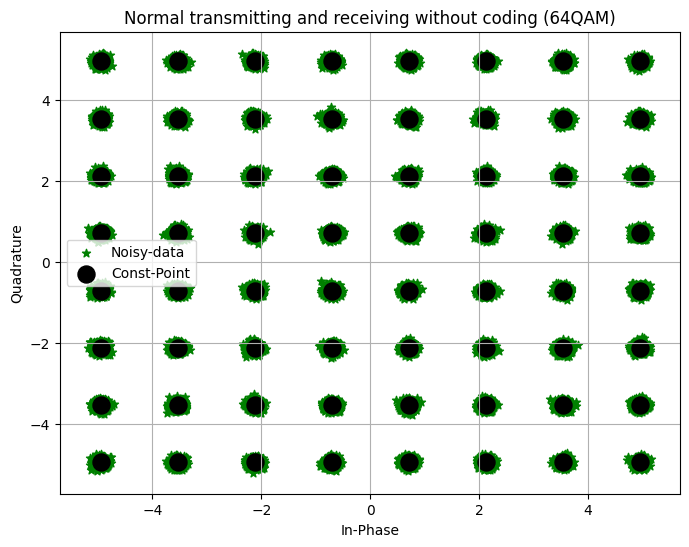

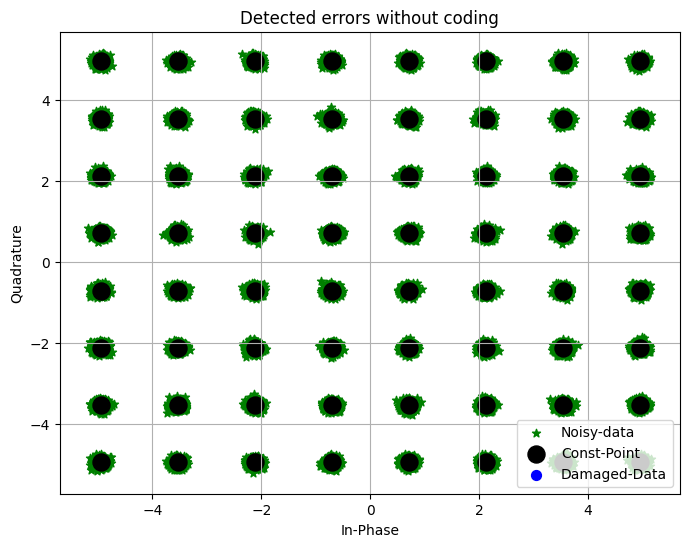

BER with RS coding: 0.49893


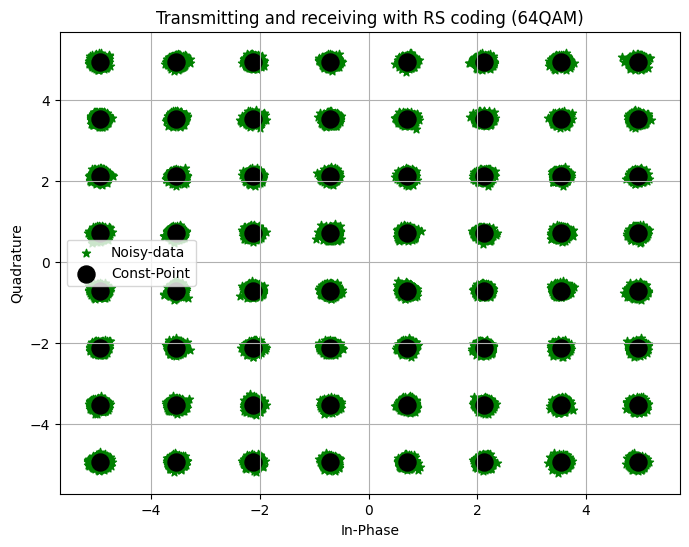

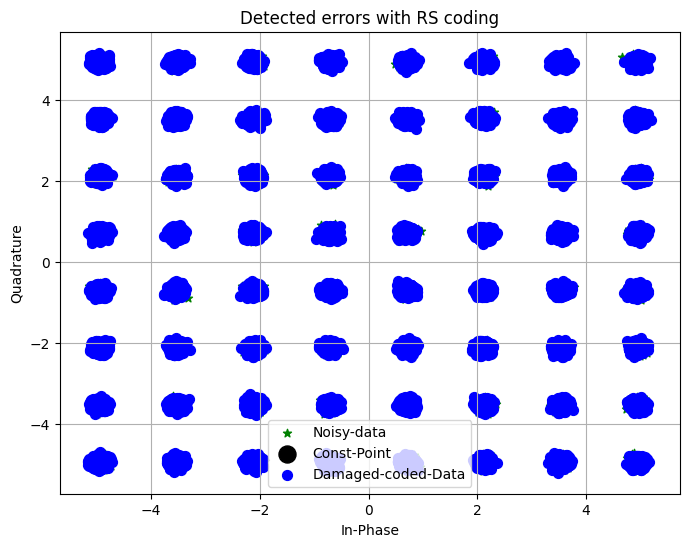

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from reedsolo import RSCodec
from scipy.signal import upfirdn

# QAM functions using NumPy
def qammod(bits, M):
    k = int(np.log2(M))
    num_symbols = len(bits) // k
    bits = bits[:num_symbols * k]
    bits_reshaped = bits.reshape((num_symbols, k))
    decimals = bits_reshaped.dot(1 << np.arange(k-1, -1, -1))

    sqrtM = int(np.sqrt(M))
    I = 2 * (decimals % sqrtM) - sqrtM + 1
    Q = 2 * (decimals // sqrtM) - sqrtM + 1
    symbols = (I + 1j * Q) / np.sqrt(2)  # unit average power
    return symbols


def qamdemod(symbols, M):
    sqrtM = int(np.sqrt(M))
    I_hat = np.round((np.real(symbols) * np.sqrt(2) + sqrtM - 1) / 2).astype(int)
    Q_hat = np.round((np.imag(symbols) * np.sqrt(2) + sqrtM - 1) / 2).astype(int)
    I_hat = np.clip(I_hat, 0, sqrtM - 1)
    Q_hat = np.clip(Q_hat, 0, sqrtM - 1)
    decimals = Q_hat * sqrtM + I_hat
    k = int(np.log2(M))
    bits = ((decimals[:, None] & (1 << np.arange(k-1, -1, -1))) > 0).astype(int)
    return bits.flatten()


def awgn(sig, EbN0_dB, k):
    EbN0 = 10**(EbN0_dB/10)
    EsN0 = EbN0 * k
    N0 = 1/EsN0
    noise_sigma = np.sqrt(N0/2)
    noise = noise_sigma * (np.random.randn(len(sig)) + 1j*np.random.randn(len(sig)))
    return sig + noise

# --- Parameters
M = 64
K = 51
N = 63
EbN0 = 13
num_blocks = 1000
k = int(np.log2(M))

# --- Data generation
data = np.random.randint(0, 2, K * k * num_blocks)

# =======================
# Part 1: WITHOUT CODING
# =======================
modData = qammod(data, M)
Const_Point = np.unique(modData)

noisy_data = awgn(modData, EbN0, k)
rwData_bits = qamdemod(noisy_data, M)
BER_no_coding = np.sum(rwData_bits != data) / len(data)
print(f"BER without coding: {BER_no_coding:.5f}")

plt.figure(figsize=(8,6))
plt.scatter(np.real(noisy_data), np.imag(noisy_data), c='g', marker='*', label='Noisy-data')
plt.scatter(np.real(Const_Point), np.imag(Const_Point), facecolor='k', s=150, edgecolor='k', label='Const-Point')
plt.grid()
plt.xlabel('In-Phase')
plt.ylabel('Quadrature')
plt.title('Normal transmitting and receiving without coding (64QAM)')
plt.legend()
plt.show()

errors_idx = np.where(rwData_bits != data)[0]
err_symbols_idx = np.unique(errors_idx // k)
Damaged_Data = noisy_data[err_symbols_idx]

plt.figure(figsize=(8,6))
plt.scatter(np.real(noisy_data), np.imag(noisy_data), c='g', marker='*', label='Noisy-data')
plt.scatter(np.real(Const_Point), np.imag(Const_Point), facecolor='k', s=150, edgecolor='k', label='Const-Point')
plt.scatter(np.real(Damaged_Data), np.imag(Damaged_Data), facecolor='b', s=50, label='Damaged-Data')
plt.grid()
plt.xlabel('In-Phase')
plt.ylabel('Quadrature')
plt.title('Detected errors without coding')
plt.legend()
plt.show()

# ================================
# Part 2: WITH REED SOLOMON CODING
# ================================
rs = RSCodec(N - K)
coded_data_bytes = []

for i in range(0, len(data), K*k):
    block_bits = data[i:i+K*k]
    block_bytes = np.packbits(block_bits)
    encoded_bytes = rs.encode(block_bytes)
    coded_data_bytes.append(np.unpackbits(encoded_bytes))

coded_data = np.concatenate(coded_data_bytes)
coded_data = coded_data[:len(coded_data) - (len(coded_data)%k)]

mod_coded_data = qammod(coded_data, M)
Const_Point2 = np.unique(mod_coded_data)
noisy_coded_data = awgn(mod_coded_data, EbN0, k)
demod_coded_bits = qamdemod(noisy_coded_data, M)

# RS Decoding
decoded_bits = []
for i in range(0, len(demod_coded_bits), N*k):
    block_bits = demod_coded_bits[i:i+N*k]
    if len(block_bits) < N*k:
        continue
    block_bytes = np.packbits(block_bits)
    try:
        decoded_bytes = rs.decode(block_bytes)
        decoded_bits.append(np.unpackbits(decoded_bytes)[:K*k])
    except:
        # Decoding failed: use zeros or erasures
        decoded_bits.append(np.zeros(K*k, dtype=int))

decoded_bits = np.concatenate(decoded_bits)
decoded_bits = decoded_bits[:len(data)]

BER_rs_coding = np.sum(decoded_bits != data) / len(data)
print(f"BER with RS coding: {BER_rs_coding:.5f}")

plt.figure(figsize=(8,6))
plt.scatter(np.real(noisy_coded_data), np.imag(noisy_coded_data), c='g', marker='*', label='Noisy-data')
plt.scatter(np.real(Const_Point2), np.imag(Const_Point2), facecolor='k', s=150, edgecolor='k', label='Const-Point')
plt.grid()
plt.xlabel('In-Phase')
plt.ylabel('Quadrature')
plt.title('Transmitting and receiving with RS coding (64QAM)')
plt.legend()
plt.show()

errors_idx = np.where(decoded_bits != data)[0]
err_symbols_idx = np.unique(errors_idx // k)
Damaged_coded_Data = noisy_coded_data[err_symbols_idx]

plt.figure(figsize=(8,6))
plt.scatter(np.real(noisy_coded_data), np.imag(noisy_coded_data), c='g', marker='*', label='Noisy-data')
plt.scatter(np.real(Const_Point2), np.imag(Const_Point2), facecolor='k', s=150, edgecolor='k', label='Const-Point')
plt.scatter(np.real(Damaged_coded_Data), np.imag(Damaged_coded_Data), facecolor='b', s=50, label='Damaged-coded-Data')
plt.grid()
plt.xlabel('In-Phase')
plt.ylabel('Quadrature')
plt.title('Detected errors with RS coding')
plt.legend()
plt.show()


RS(255,239) Forward Error Correction Code in Optical Systems


## Reed–Solomon (RS) Codes: Theory

Reed–Solomon codes are **block-based error correction codes** defined over **finite fields (Galois fields, GF)**.

An RS code is specified as RS(n, k) over GF(q), with:

* n = number of symbols in a codeword
* k = number of data symbols
* n − k = number of parity symbols

**RS(255,239)** is over GF(2^8):

* n = 255 symbols (bytes)
* k = 239 symbols (bytes)
* 16 parity symbols

It can correct up to t errors:

$$
t = \frac{n - k}{2} = 8
$$


### Finite Field: GF(2^8)

RS codes operate over finite fields. For RS(255,239):

* Field is GF(2^8), with 256 elements.
* Arithmetic is done modulo an irreducible polynomial.

For GF(2^8), a common primitive polynomial is:

$$
x^8 + x^4 + x^3 + x^2 + 1
$$


### Encoding

1. The message is a polynomial M(x) of degree < k.
2. The codeword is:

$$
C(x) = M(x) \cdot x^{n - k} + R(x)
$$

where R(x) is the remainder when $M(x) \cdot x^{n - k}$ is divided by the **generator polynomial** G(x).


### Generator Polynomial

The generator polynomial G(x) is chosen to have 2t consecutive powers of a primitive element α as roots:

$$
G(x) = (x - \alpha^1)(x - \alpha^2)\ldots(x - \alpha^{2t})
$$

For RS(255,239), G(x) has 16 roots in GF(2^8).


### Decoding

Decoding typically uses:

1. **Syndrome calculation**: Compute S\_i = C(α^i).
2. **Berlekamp–Massey algorithm**: Finds the error locator polynomial.
3. **Chien search**: Finds error positions.
4. **Forney’s formula**: Finds error magnitudes.
5. **Error correction**: Corrects errors in the received codeword.


### Properties

* Burst error correction: RS codes excel at correcting bursts of errors.
* Systematic: The original message appears in the codeword.
* Used in optical transport (e.g., ITU-T G.709).


## Practical Notes on RS(255,239)

* 8-bit symbols (bytes)
* 239 data bytes + 16 parity bytes
* Can correct up to 8 byte errors per codeword

This was standard in SONET/SDH, optical transport networks (OTN), and early DWDM systems.


> more detailed math (e.g., Berlekamp–Massey derivation, generator polynomial construction, syndrome equations)



In [22]:
import reedsolo
import numpy as np

# Initialize RS(255,239)
n = 255
k = 239
nsym = n - k  # 16 parity symbols

# Create RS codec
rs = reedsolo.RSCodec(nsym)

# Generate random data (239 bytes)
message = np.random.randint(0, 256, k, dtype=np.uint8)
print("Original message:")
print(message)

# Encode
codeword = rs.encode(message.tobytes())
print("\nEncoded codeword (length 255):")
print(list(codeword))

# Simulate transmission with errors
# Introduce up to 8 errors (correctable)
error_codeword = bytearray(codeword)
num_errors = 8
error_positions = np.random.choice(range(n), num_errors, replace=False)
for pos in error_positions:
    error_codeword[pos] ^= np.random.randint(1, 256)  # Flip bits

print("\nError positions:", error_positions)
print("Codeword with errors:")
print(list(error_codeword))

# Decode
try:
    decoded = rs.decode(bytes(error_codeword))
    print("\nDecoded message:")
    print(list(decoded))
    if decoded == message.tobytes():
        print("\nDecoding successful. Errors corrected.")
    else:
        print("\nDecoding failed. Output does not match original.")
except reedsolo.ReedSolomonError as e:
    print("\nDecoding failed:", e)


Original message:
[217 128 163  38 113 196  36 175  73  91  68  48   2 196  36  42  19 219
 216 216  92  93 123 215 203  92  87 212  93 118  13  96 109  40   0  32
 226 195  13 171 122 197  35 191 109 178  35 228  56  71 182  98 235  61
 186 241 168 109 236  59  65  64 132 157  40  85 231 250 197  47  81  32
 130 146 216  89 162 240  97  82  49   6  16  68 247   6  60 226  99 205
 129 101  50  94  51   0  13 196  19 217 176 246 127   1 143 229 204 216
   5 114 217  63  13 119   5  42 139  17 147 191 167  95  43  60  91 145
  82 126 241 243 158 140  23  64  60 253 126 150 188 215 162  99 189 129
 208 232  93 255  74 221  97  60 127  53  74 163  61 108 173 186  18 105
  23 237 230 156  36  13 156   9 198  37  70 213  15  26  85 121 213  60
 130 107 198  10  28 146  30 107  67 174 108 180 160 163  89 186  74 247
  89 241  72 129 160 238  52  80 220 162 140 124 151  13   8 235 102   7
  13 218  20  51 220 131  60 133 201 248  35 165 246 132   1  46 216 102
 151  63  92 124 244]

Encoded co


* This simulation is symbol-based (bytes), matching the field GF(2^8).
* In real optical transport equipment, RS encoding and decoding is performed in hardware or firmware.
* Standards like ITU-T G.709 specify exact FEC framing and overhead.
---
---

# **BCH codes used in ITU-T G.975** 


## BCH Codes: General Theory

BCH (Bose–Chaudhuri–Hocquenghem) codes are **cyclic linear block codes** over GF(q), typically **GF(2)**.

An **(n, k, t)** BCH code over GF(2):

* n = codeword length
* k = data length
* t = designed error correction capability (corrects up to t bit errors)

Key properties:

* Algebraic construction using minimal polynomials
* Cyclic: any cyclic shift of a codeword is also a codeword
* Powerful for binary error correction

---

### Construction

1. Choose the field GF(2^m) such that n ≤ 2^m - 1.
2. Choose primitive element α of GF(2^m).
3. Define generator polynomial:

$$
g(x) = \text{lcm} \{ M_1(x), M_2(x), \ldots, M_{2t}(x) \}
$$

where $M_i(x)$ is the minimal polynomial of $\alpha^i$ over GF(2).

This guarantees that the code has **2t consecutive roots**:

$$
g(\alpha^i) = 0, \quad i = 1, 2, \ldots, 2t
$$

---

## BCH Codes in Optical Submarine Systems (ITU-T G.975)

ITU-T G.975 (for submarine optical systems) defines a **binary BCH code** as its standard FEC:

* n = 1023
* k = 973
* t = 10

**Meaning**:

* Codeword length: 1023 bits
* Message length: 973 bits
* Parity bits: 50
* Corrects up to 10 bit errors in any codeword

This is a **binary BCH(1023,973,10)** code over GF(2^10).

GF(2^10) has 1024 elements, so:

$$
n = 2^{10} - 1 = 1023
$$

---

### Generator Polynomial

The generator polynomial g(x):

* Has roots $\alpha^1, \alpha^2, \ldots, \alpha^{20}$ in GF(2^10)
* Constructed as LCM of their minimal polynomials over GF(2)

$$
g(x) = \text{lcm} \left\{ M_1(x), M_2(x), \ldots, M_{20}(x) \right\}
$$

This ensures any error pattern of up to 10 bits can be corrected.

---

### FEC Overhead

$$
\text{Overhead} = \frac{n - k}{k} = \frac{50}{973} \approx 5.14\%
$$

Low overhead was crucial for long-haul submarine systems.

---

## Decoding Theory

**Key decoding steps:**

1. **Syndrome Computation**
   Compute syndromes $S_i = r(\alpha^i)$ for i = 1..2t.

2. **Berlekamp–Massey Algorithm**
   Solve for the error-locator polynomial:

$$
\Lambda(x) = 1 + \Lambda_1 x + \ldots + \Lambda_t x^t
$$

This polynomial’s roots correspond to error locations in the codeword.

3. **Chien Search**
   Efficiently finds roots of $\Lambda(x)$ over GF(2^10).

4. **Forney’s Formula**
   Computes error magnitudes (for binary BCH, always 1).

5. **Error Correction**
   Corrects bits at identified locations.

---

## Advantages for Submarine Systems

* High coding gain (\~6–7 dB improvement in required OSNR)
* Low overhead (\~5%)
* Extremely low post-FEC BER (often <10^-15)
* Robust against random bit errors and some burst errors

---

## Practical Use in ITU-T G.975

* Used in 2.5 Gbps submarine optical transport
* Provided error correction with minimal latency
* Typically implemented in ASICs or DSP blocks in transponders

---

### Notes

* The ITU-T G.975 submarine standard uses **GF(2^10)** with **n=1023**, which is too large for many hobby libraries.
* The example uses **GF(2^8)** (n=255) but demonstrates the exact same theory.
* Hardware/firmware in optical transponders implements the full 1023-bit BCH efficiently.


In [ ]:
import bchlib
import os
import random

POLYNOMIAL = 8219  # Example: primitive polynomial for BCH(127, 64, t=10)
t = 10             # Correct up to 10 errors

bch = bchlib.BCH(POLYNOMIAL, t)

print(f"BCH initialized with t={t}")
print(f"Data bytes: {bch.k_bytes}, ECC bytes: {bch.ecc_bytes}")

# Random message
data = os.urandom(bch.k_bytes)
print("\nOriginal data (hex):")
print(data.hex())

# Encode
ecc = bch.encode(data)
print("\nECC (hex):")
print(ecc.hex())

# Add errors
codeword = bytearray(data + ecc)
for _ in range(t):
    pos = random.randint(0, len(codeword)-1)
    codeword[pos] ^= 1

print("\nCorrupted codeword (hex):")
print(codeword.hex())

# Decode
data_in = codeword[:-bch.ecc_bytes]
ecc_in = codeword[-bch.ecc_bytes:]
bitflips = bch.decode_inplace(data_in, ecc_in)

print("\nCorrected bitflips:", bitflips)
print("Decoded data (hex):")
print(data_in.hex())

if data == data_in:
    print("\nDecoding successful. Errors corrected.")
else:
    print("\nDecoding failed.")


# LDPC for 100G/400G coherent systems


## LDPC Codes

* Linear block codes defined by a sparse parity-check matrix **H**.
* Invented by Gallager in 1960s, rediscovered in 1990s.
* Capacity-approaching codes: can get arbitrarily close to Shannon limit with low error rates.

**Key feature**: Sparse H matrix enables iterative decoding (belief propagation or sum-product) with feasible complexity.


## General Form

An LDPC code is defined by:

$$
\mathbf{H} \cdot \mathbf{c}^T = 0
$$

* $\mathbf{c}$ is the codeword vector.
* $\mathbf{H}$ is an $m \times n$ sparse parity-check matrix.
* Typically $n \gg m$, so code rate $R \approx 1 - m/n$.


## Tanner Graph Representation

LDPC codes are visualized using **bipartite Tanner graphs**:

* Variable nodes (bits of the codeword)
* Check nodes (parity-check equations)

Edges represent non-zero entries in H.

Sparse H → sparse graph → efficient message passing.



## Encoding

While defined by **H**, practical systems use or derive **generator matrix G**:

$$
\mathbf{c} = \mathbf{u} \cdot \mathbf{G}
$$

* G can be derived from H (but costly in hardware).
* In high-speed optical systems, specialized encoders (e.g., accumulators) produce parity systematically.



## Decoding

Uses **iterative message passing**:

* Sum-Product Algorithm (SPA) in log-domain (Log-SPA)
* Min-Sum Algorithm (simplified, approximated SPA)

Key steps:

1. Initialize log-likelihood ratios (LLRs) from channel observations.
2. Pass messages between variable nodes and check nodes iteratively.
3. Make hard decisions after convergence or maximum iterations.

LDPC decoding is **soft-decision** FEC (SD-FEC):

* Uses real-valued LLR inputs from the receiver.
* Higher coding gain than hard-decision FEC (HD-FEC).


## LDPC in 100G/400G Optical Coherent Systems

Modern optical transport (e.g., 100G, 200G, 400G, 800G) uses:

* Coherent detection (I/Q sampling)
* DSP for equalization, carrier recovery, polarization demux
* Forward Error Correction (FEC)

**ITU-T G.709** (OTN) defines FEC for optical transport networks:

* Older systems: RS(255,239) — hard-decision FEC (HD-FEC)
* Modern coherent systems: LDPC codes — soft-decision FEC (SD-FEC)

**Reason**:

* Coherent receivers can generate soft outputs (LLRs).
* LDPC decoders exploit soft information → 2–3 dB coding gain improvement over HD-FEC.


## Example Standards

**G.709.2 (2016) / G.709.3 / G.709.4**

Define SD-FEC with LDPC codes:

* LDPC codeword lengths \~20,000 bits or more.
* Code rates \~0.8–0.9.
* Typically quasi-cyclic (QC-LDPC) structures for efficient hardware implementation.

**Example**: 400G Optical Transport

* LDPC code rate \~0.83
* Codeword length \~20k bits
* Structured parity-check matrix with circulant submatrices for parallelization.



## Coding Gain

Soft-decision LDPC FEC in coherent optical systems:

* HD-FEC net coding gain \~6–7 dB (e.g., RS)
* SD-FEC net coding gain \~10–12 dB

This allows:

* Longer reach
* Higher capacity per wavelength
* Fewer regenerators/repeaters


## LDPC Matrix Structure for Hardware

* Very large matrices (tens of thousands of bits)
* Must be highly structured (quasi-cyclic or block-circulant) for ASIC/FPGA implementation
* Each submatrix is a circulant permutation → enables parallel decoding



## Decoding Complexity

Iterative decoder:

* 5–20 iterations typical.
* Message-passing hardware highly parallelized.
* Latency and power critical at 100G/400G/800G.



## Typical Use in DSP Chain

Receiver DSP:

* Coherent detection (I/Q sampling)
* Chromatic dispersion compensation
* Polarization demux
* Carrier phase recovery
* Soft-symbol generation → LLRs
* LDPC soft-decision decoding


## Summary of Benefits

* LDPC codes close to Shannon limit
* Large block lengths mitigate error floors
* Soft-decision decoding yields high coding gain
* Standardized in modern optical transport (G.709.x)


## Typical Parameters for Commercial Systems

| System    | Code Type     | Rate    | Length        | Gain (dB)  |
| --------- | ------------- | ------- | ------------- | ---------- |
| 100G OTN  | RS(255,239)   | \~0.937 | 2040 bits     | \~6 dB     |
| 100G/400G | LDPC (SD-FEC) | \~0.83  | \~20,000 bits | \~10–12 dB |


**Notes**:

* `pyldpc` is for small-scale academic codes.
* Real systems use QC-LDPC matrices with n \~ 20,000 or more.
* Real decoders use hundreds of parallel processing elements.

##  Standards References

* ITU-T G.709.2/Y.1331.2: Optical Transport Network interfaces with soft-decision FEC
* IEEE 802.3bs: 400GBASE-R with LDPC
* OIF (Optical Internetworking Forum) implementation agreements





Code rate: 51/100
Message:
[0 0 0 0 1 0 0 0 1 1 1 0 0 0 0 0 1 1 1 0 1 1 1 0 0 0 1 1 1 1 0 1 0 0 0 0 0
 0 1 0 1 0 0 0 0 1 0 0 1 1 1]
Codeword:
[ 0.75906672  0.62416165  0.94197927  1.02592066 -0.87663656  0.71945023
  0.91319779  1.3526461  -0.73982624 -0.97779362 -0.86623412  0.72604576
  1.40153528  1.00604567  0.45598805  0.77389964 -1.11143577 -1.00812974
 -0.21149397  1.21538316 -0.75499381 -0.98636652 -0.79829438  1.32722549
  1.40430093  1.03241274 -1.40313499 -1.11560062 -1.17888539 -1.11601979
  1.32646749 -0.95239174  1.10460054  1.33753529  1.56992488  1.15687871
  1.34378001  1.36463753 -1.57158148  0.92673259 -0.45563686  1.23052023
  0.90452251  0.92610069  0.493024   -0.54906474  0.55111273  1.24417723
 -1.04174909 -1.26498415 -1.24016538  1.25518591 -1.25322656  0.7388405
 -1.20686705 -0.65307959  0.99538939 -0.61593977  0.88361761 -0.92986052
  1.0160885   0.55957321 -0.75461666  0.90547443 -0.7845211  -1.15893183
 -1.32312541  0.7912114  -0.98974968  0.99420498 -0.7701

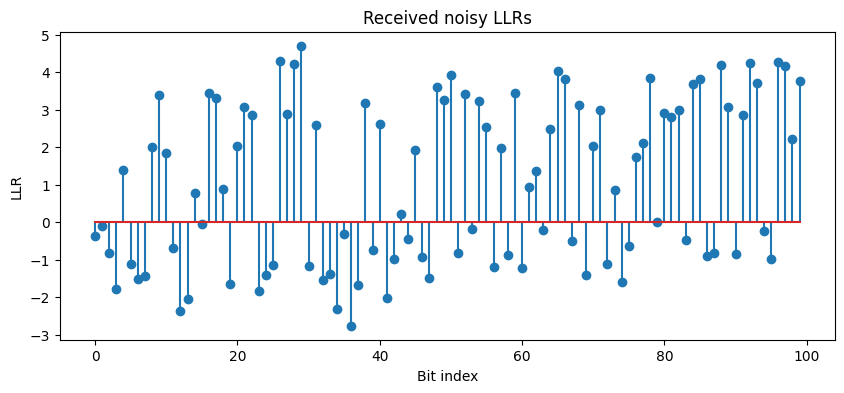

In [ ]:
import numpy as np
from pyldpc import make_ldpc, encode, decode, get_message
import matplotlib.pyplot as plt

# Create a small LDPC code for demonstration
n = 100  # codeword length
d_v = 2  # variable node degree
d_c = 4  # check node degree
systematic = True

H, G = make_ldpc(n, d_v, d_c, systematic=systematic, sparse=True)
k = G.shape[1]
print(f"Code rate: {k}/{n}")

# Generate random message
message = np.random.randint(0, 2, k)
print("Message:")
print(message)

# Encode
codeword = encode(G, message, snr=10)
print("Codeword:")
print(codeword)

# Add noise
snr_db = 2.0
sigma = np.sqrt(1/(2*10**(snr_db/10)))
noise = sigma * np.random.randn(n)
received = 1 - 2*codeword + noise

# Decode (belief propagation)
decoded = decode(H, received, snr_db, maxiter=50)
decoded_message = get_message(G, decoded)

print("Decoded message:")
print(decoded_message)

# Check success
if np.all(decoded_message == message):
    print("Decoding successful.")
else:
    print("Decoding failed.")

# Optional: plot
plt.figure(figsize=(10,4))
plt.stem(received)
plt.title("Received noisy LLRs")
plt.xlabel("Bit index")
plt.ylabel("LLR")
plt.show()


---
---

# An implementation for DWDM coherent optical systems using a *proper FEC*.

## System Model (Simplified)

DWDM Coherent Optical Link typical flow:

* Transmitter:

  * Data bits
  * FEC encoding
  * Modulation (e.g., QPSK or 16QAM)
* Channel:

  * Additive noise (ASE noise)
  * Linear impairment (dispersion/phase noise – often modeled simply as AWGN in simulation)
* Receiver:

  * Coherent detection
  * Soft-decision generation (LLRs)
  * FEC decoding

We will **simplify**:

* Modulation: QPSK
* Channel: AWGN only
* FEC: LDPC code (soft-decision)


## Choice of FEC

Real coherent systems use **SD-FEC** (Soft-Decision Forward Error Correction):

* LDPC is standard in 100G/400G OTN.
* ITU-T G.709.2 specifies LDPC-based SD-FEC.

We will **model this** with an LDPC code:

* Moderate blocklength (real systems \~20,000 bits, but for simulation \~500–1000 is practical).
* Soft-input decoding with LLRs.


## Why LDPC (Soft Decision)?

Coherent receivers generate **soft decisions** (LLRs), which:

* Improve coding gain
* Enable operation near Shannon limit


## Steps in Simulation

* Random bit generation
* FEC encoding
* QPSK modulation
* AWGN channel
* Coherent receiver → LLRs
* LDPC decoding


### Explanation

* **LDPC code** with rate \~0.8
* **QPSK modulation** (common in coherent optical systems)
* **AWGN channel** models ASE noise in DWDM systems
* **Soft-decision LLRs** computed from received symbols
* **LDPC decoding** uses these LLRs to correct errors



### Notes

* Real coherent receivers generate soft LLRs from DSP blocks, matched filtering, and carrier recovery.
* Real LDPC matrices are quasi-cyclic with \~20,000–60,000 bits for 400G.
* This example scales down for tractable simulation but preserves **all key principles**.




LDPC code rate: 0.502
Random message bits: [1 1 0 1 1 1 0 1 0 0 1 1 1 0 0 1 1 1 1 1]...
Encoded codeword (first 20 bits): [-0.46272699 -1.26081069  0.42073587 -1.40153734 -1.03684671 -1.09898375
  0.72157715 -1.52862317  0.56121015  1.29108267 -1.32337577 -0.50844642
 -0.86166872  1.3664887   0.82688653 -0.87711155 -1.42125324 -0.89149252
 -0.9363022  -1.44999432]...
Number of QPSK symbols: 256
Number of bit errors after decoding: 113
Decoding incomplete. Residual errors remain.


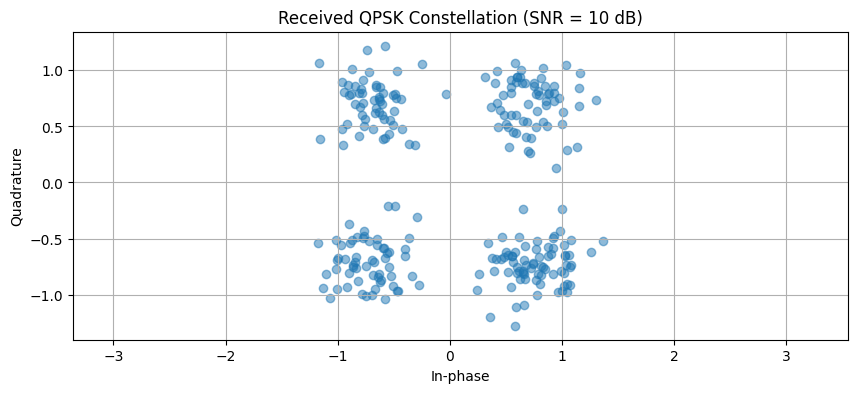

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from pyldpc import make_ldpc, encode, decode, get_message

# LDPC code parameters
n_bits = 512
d_v = 2
d_c = 4
systematic = True

# Create LDPC matrices
H, G = make_ldpc(n_bits, d_v, d_c, systematic=systematic, sparse=True)
k_bits = G.shape[1]
rate = k_bits / n_bits
print(f"LDPC code rate: {rate:.3f}")

# Generate random message
message = np.random.randint(0, 2, k_bits)
print(f"Random message bits: {message[:20]}...")

# SNR parameters
snr_db = 10
snr_linear = 10**(snr_db/10)

# Encode the message (corrected function call)
codeword = encode(G, message, snr_linear)
print(f"Encoded codeword (first 20 bits): {codeword[:20]}...")

def qpsk_mod(bits):
    """QPSK modulation function"""
    # Convert to binary bits (in case encode returns soft values)
    bits = (bits > 0).astype(int)
    
    # Pad bits if odd length
    if len(bits) % 2 == 1:
        bits = np.append(bits, 0)
    
    bits = bits.reshape(-1, 2)
    mapping = {
        (0,0): 1+1j,
        (0,1): -1+1j,
        (1,1): -1-1j,
        (1,0): 1-1j
    }
    symbols = np.array([mapping[tuple(b)] for b in bits]) / np.sqrt(2)
    return symbols

# Modulate
symbols = qpsk_mod(codeword)
print(f"Number of QPSK symbols: {len(symbols)}")

# Add AWGN noise
noise_power = 1 / (2*snr_linear)
noise = np.sqrt(noise_power) * (np.random.randn(*symbols.shape) + 1j*np.random.randn(*symbols.shape))
rx_symbols = symbols + noise

def qpsk_llr(received_symbols, noise_var):
    """Calculate Log-Likelihood Ratios for QPSK"""
    llrs = []
    for s in received_symbols:
        # LLR for I and Q components
        llr_I = 2 * s.real / noise_var
        llr_Q = 2 * s.imag / noise_var
        llrs.extend([llr_I, llr_Q])
    return np.array(llrs)

# Calculate LLRs
llrs = qpsk_llr(rx_symbols, noise_power)

# Trim LLRs to match codeword length if needed
if len(llrs) > len(codeword):
    llrs = llrs[:len(codeword)]

# Decode (corrected function call)
decoded_bits = decode(H, llrs, snr_linear, maxiter=50)
decoded_message = get_message(G, decoded_bits)

# Check for errors
errors = np.sum(decoded_message != message)
print(f"Number of bit errors after decoding: {errors}")

if errors == 0:
    print("Decoding successful. All errors corrected.")
else:
    print("Decoding incomplete. Residual errors remain.")

# Plot constellation
plt.figure(figsize=(10,4))
plt.scatter(rx_symbols.real, rx_symbols.imag, alpha=0.5)
plt.title(f"Received QPSK Constellation (SNR = {snr_db} dB)")
plt.xlabel("In-phase")
plt.ylabel("Quadrature")
plt.grid(True)
plt.axis('equal')
plt.show()

ITU-T G.975: FEC for submarine optical systems.
ITU-T G.709: OTN (Optical Transport Network) framing with FEC.
IEEE 802.3bs: FEC for 400G Ethernet.